In [16]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
sns.set(style="darkgrid")


## Transformations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## Feature Reduction Analyis
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

## Analaysis
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind
import scipy.stats 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import auc

## Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import statsmodels.api as sm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## State for all randomness
randomState = 17

In [2]:
# ## Larger data set with 40+ features
# names = list(pd.read_csv(os.path.join(os.getcwd(),"fullSet","names2.csv"))['modName'])

# df = pd.read_csv(os.path.join(os.getcwd(),"fullSet","census-income.data"), index_col=False, names=names)
# df.describe()

## Data Cleaning
This includes the first step to handle any missing data, outliers, or redundant entries (if applicable)
Reference:
* Decsription of the feature - https://rpubs.com/Net/IncomeLevelClassification
* https://github.com/JcFreya/Adult-Census-Income/blob/master/AF%20Data%20Science%20Project.ipynb
* https://github.com/saravrajavelu/Adult-Income-Analysis/blob/master/Adult_Income_Analysis.ipynb 

In [17]:
## Smaller data set with ~10 features
colNames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
           'relationship', 'race','sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

dfTrain = pd.read_csv(os.path.join(os.getcwd(),"subset","adult.data"), index_col=False, names = colNames)
dfTest = pd.read_csv(os.path.join(os.getcwd(),"subset","adult.test"), index_col=False, names = colNames)
df = pd.concat([dfTrain,dfTest.iloc[1::]])

## Don't require fnlwgt for analysis
df.drop(columns=["fnlwgt"], inplace = True)

# Read in age as int type
df['age'] = df.age.astype(int)

## Map target dataset to binary 
df.income = df.income.map({' <=50K': 0, ' <=50K.': 0, ' >50K':1, ' >50K.':1})

# Identify null
print(f"Results of Na in the dataset:\n{df.isna().sum()}")

# Identify any filler entries that act as null
print("--------------------------------------")
print("Identify any NaN fillers, '?', and convert their entry to np.nan.\n\
Also, want to determine the percentage of data fillers make up to determine\n\
proceeding steps.\n")
for i in df.columns:
    res = len(df[df[i] == ' ?'])
    if res != 0:
        print(f"{i}: {res} records with '?' as entry")
        print(f"This makes up {100*res/len(df):0.2f}% of the dataset\n")
        df.loc[df[i]==' ?', i] = np.nan
missData = 100*len(df[df.workclass.isna() | df.occupation.isna() |  df["native-country"].isna()])/len(df)
print(f"If I were to handle missing data by removing those entries all together that would make up {missData:0.2f}% of the data removed")
print(f"Because I believe I can still obtain a reliable model while still removing {missData:0.2f}% of data,\n\
I will proceed with removing those entries.")
df.dropna(inplace = True)

# Strip data on left side since there seems to be an additional space between entry
catData = set(df.columns) - set(df.describe().columns)
numData= list(set(df.columns)-catData - {"income"})
for i in catData:
    df[i] = df[i].str.lstrip()
    


Results of Na in the dataset:
age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
--------------------------------------
Identify any NaN fillers, '?', and convert their entry to np.nan.
Also, want to determine the percentage of data fillers make up to determine
proceeding steps.

workclass: 2799 records with '?' as entry
This makes up 5.73% of the dataset

occupation: 2809 records with '?' as entry
This makes up 5.75% of the dataset

native-country: 857 records with '?' as entry
This makes up 1.75% of the dataset

If I were to handle missing data by removing those entries all together that would make up 7.41% of the data removed
Because I believe I can still obtain a reliable model while still removing 7.41% of data,
I will proceed with removing th

## Exploring Income vs. Categorical Features 
Reference: 
* Guide from other user: https://github.com/saravrajavelu/Adult-Income-Analysis/blob/master/Adult_Income_Analysis.ipynb
* CrossTab: https://towardsdatascience.com/meet-the-hardest-functions-of-pandas-part-ii-f8029a2b0c9b

This section explores the relationship between income and categorical features in a graphical format

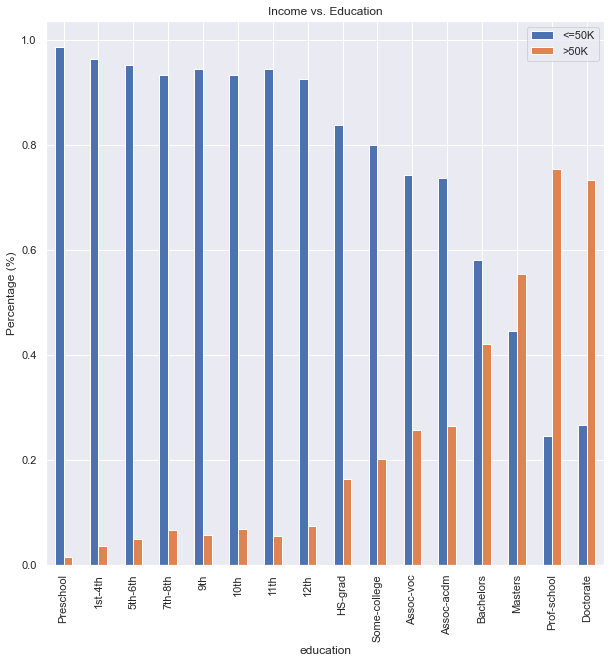

In [18]:
## If I want to have the data sorted by the education level rather than by >50K composition
edu_level = {}
for x,y in df[['education-num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

groupbyEdu = df.groupby(['education', 'income']).income.count().unstack()
groupbyEdu = groupbyEdu.div(groupbyEdu.apply(sum,1),0)

groupbyEdu= groupbyEdu.reindex(sorted(edu_level, key=edu_level.get, reverse=False))
eduPlot = groupbyEdu.plot(kind="bar", 
                          figsize=(10, 10), 
                          title="Income vs. Education",
                         ylabel = 'Percentage (%)')
plt.legend(["<=50K", ">50K"])
plt.show()

In [431]:
# # Bin hours per week into four categories for visualization purposes only
# df.loc[df['hours-per-week'].between(0, 40, 'left'), 'hoursPerWeek'] = '<40'
# df.loc[df['hours-per-week'].between(40, 60, 'left'), 'hoursPerWeek'] = '<60'
# df.loc[df['hours-per-week'].between(60, 80, 'left'), 'hoursPerWeek'] = '<80'
# df.loc[df['hours-per-week'].between(80, 100, 'both'), 'hoursPerWeek'] = '>=80'
# catData = catData|{'hoursPerWeek'}

# groupbyAll = {}
# fig, axes = plt.subplots(4,2)
# j=-1
# for i, name in enumerate(catData):
#     if i%2==0:
#         j+=1
#     data = df.groupby([name,"income"])["income"].count().unstack()
#     data = data.div(data.apply(sum,1),0)
#     data.sort_values(by = 1, inplace = True)
#     data.plot(kind="bar",subplots=False, title= (name + " vs. Income").title(),
#               ylabel = 'Percentage (%)', ax=axes[j,i%2], figsize=(15,15))
#     plt.legend(["<=50K", ">50K"]);
#     groupbyAll[i] = data
    

# plt.show()
    
# # Drop hoursPerWeek & education for the remainder of the modeling since education-num gives the same information
# # as education and hoursPerWeek were only used for visualization
# # df.drop(columns=["hoursPerWeek", "education"], inplace = True)
# # catData = catData - {'hoursPerWeek', 'education'}

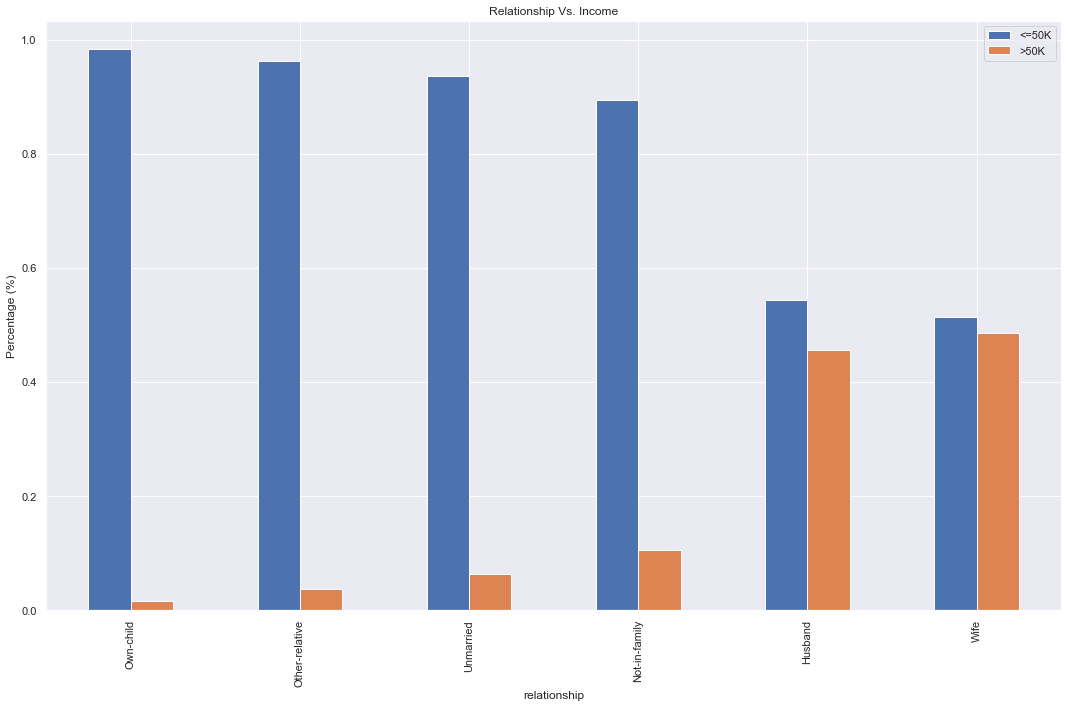

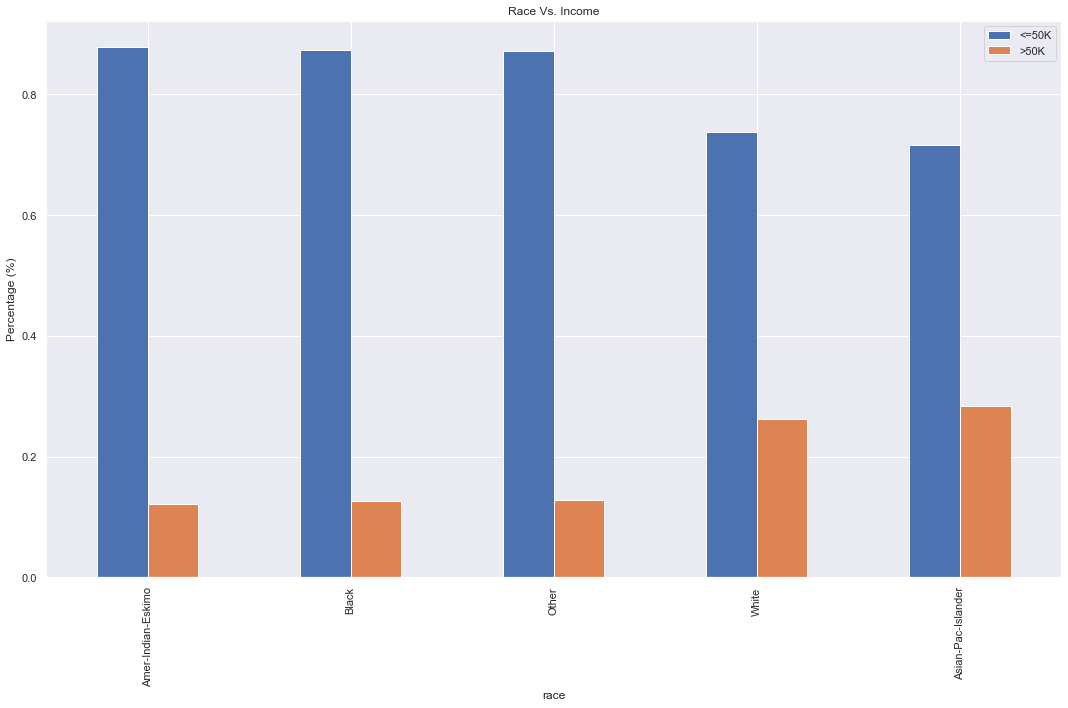

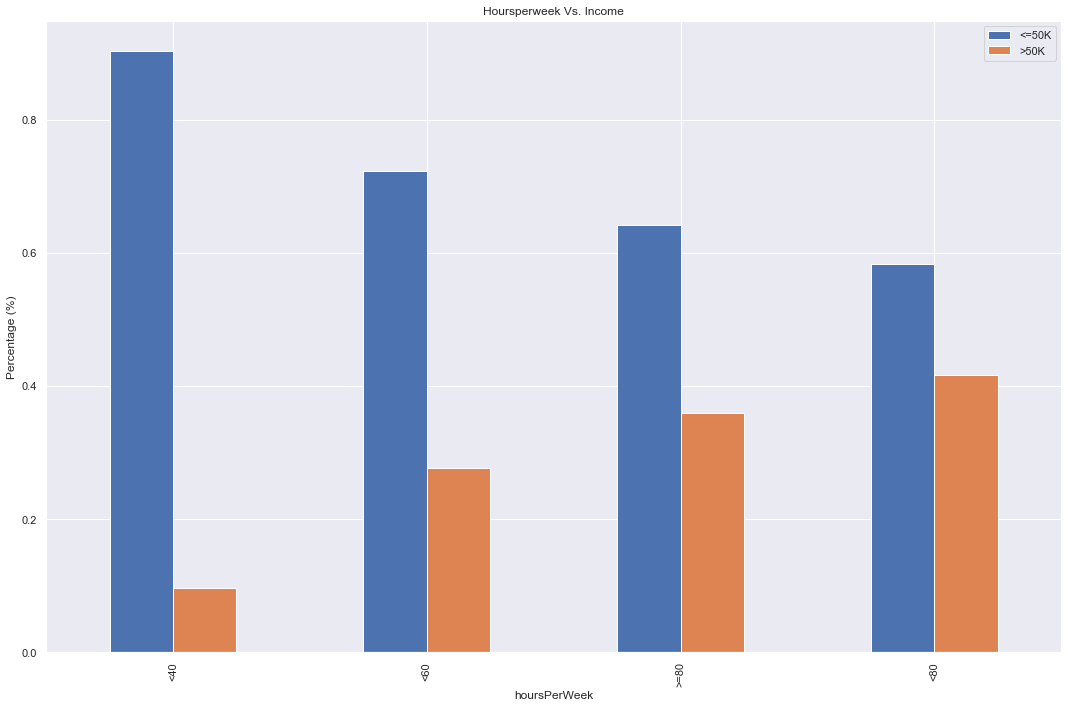

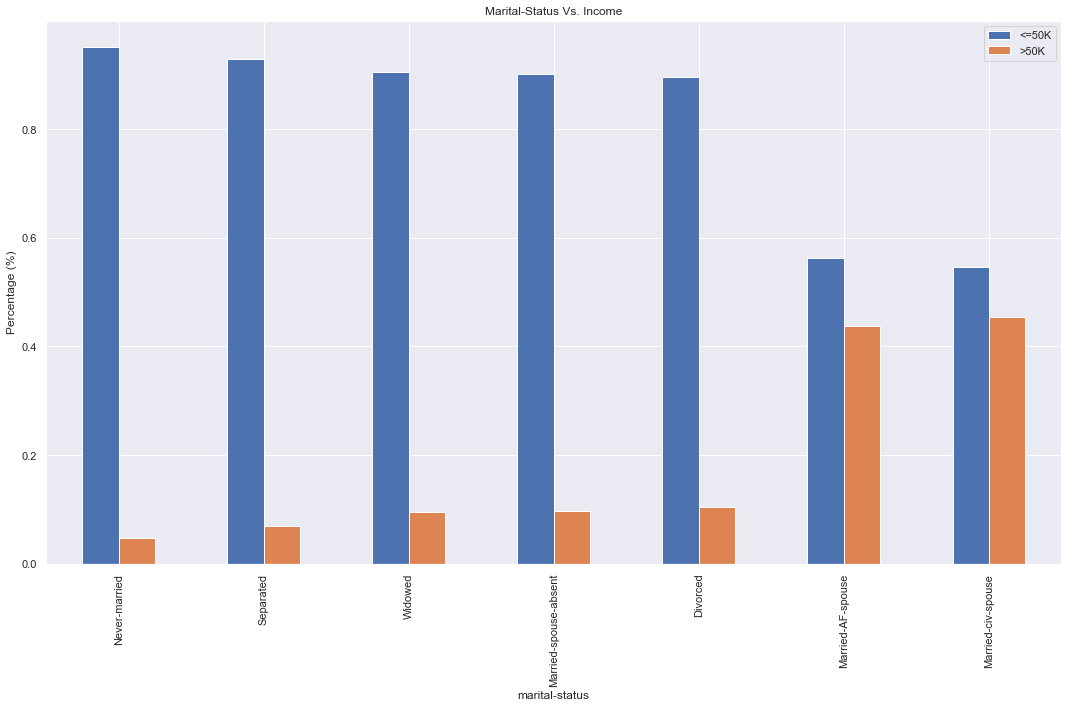

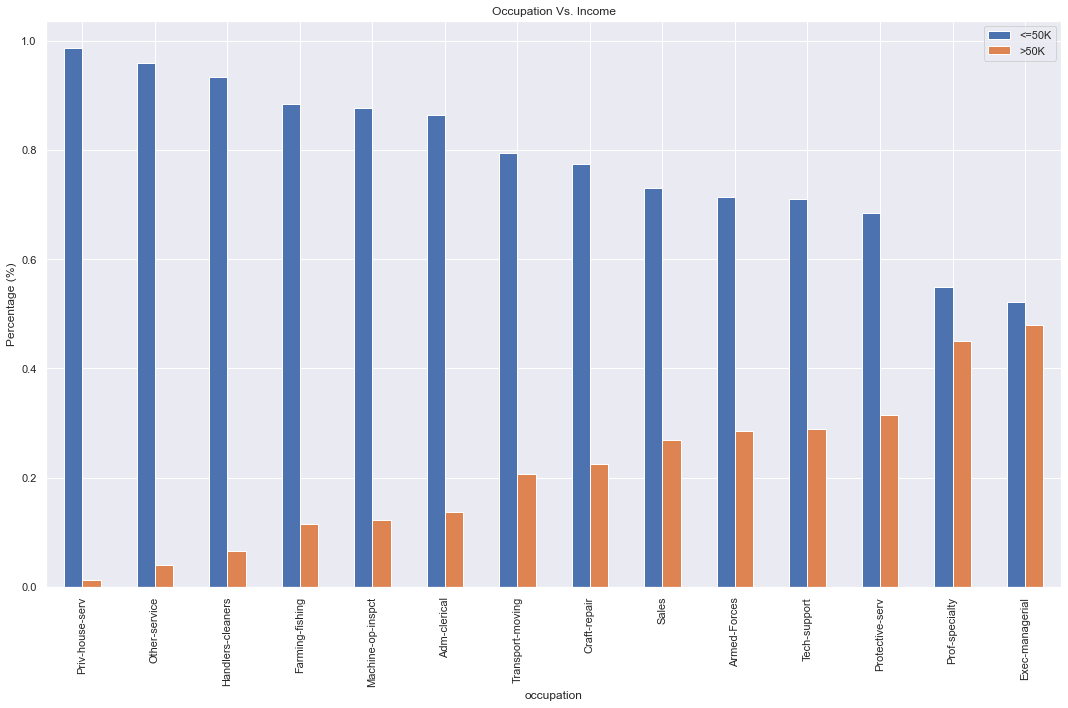

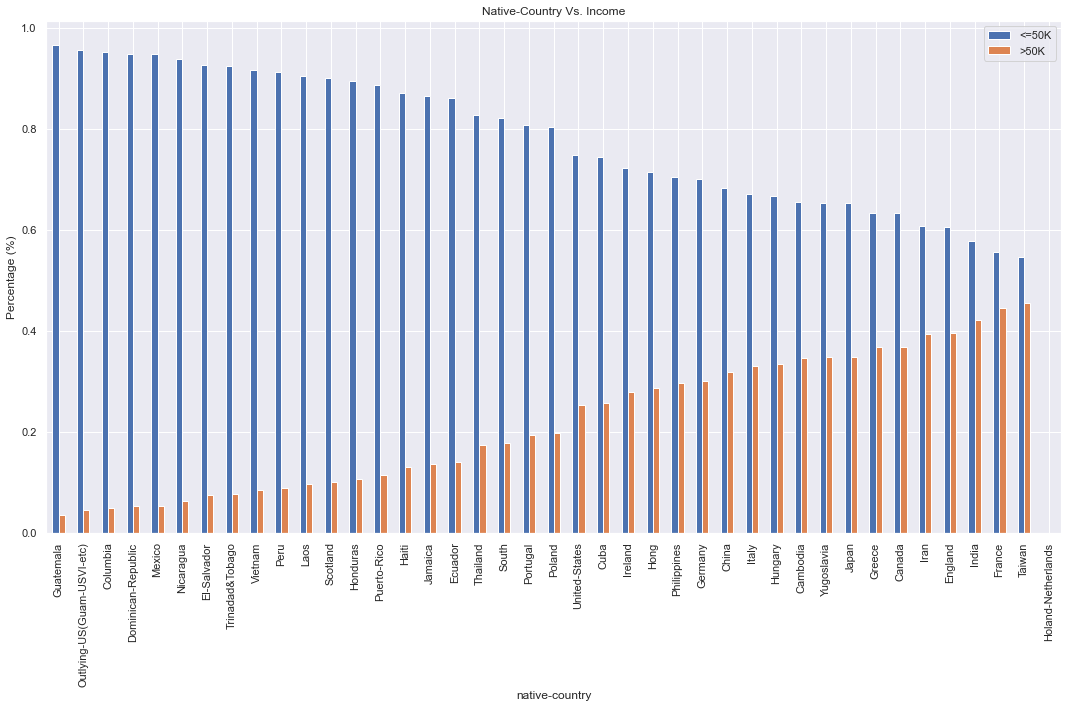

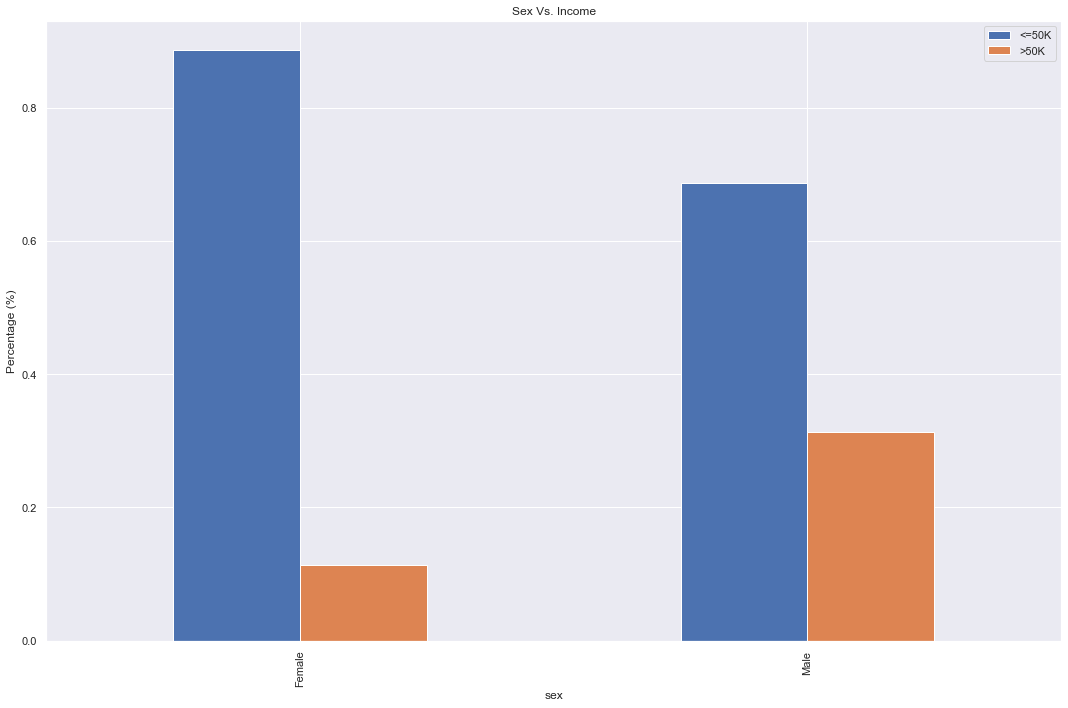

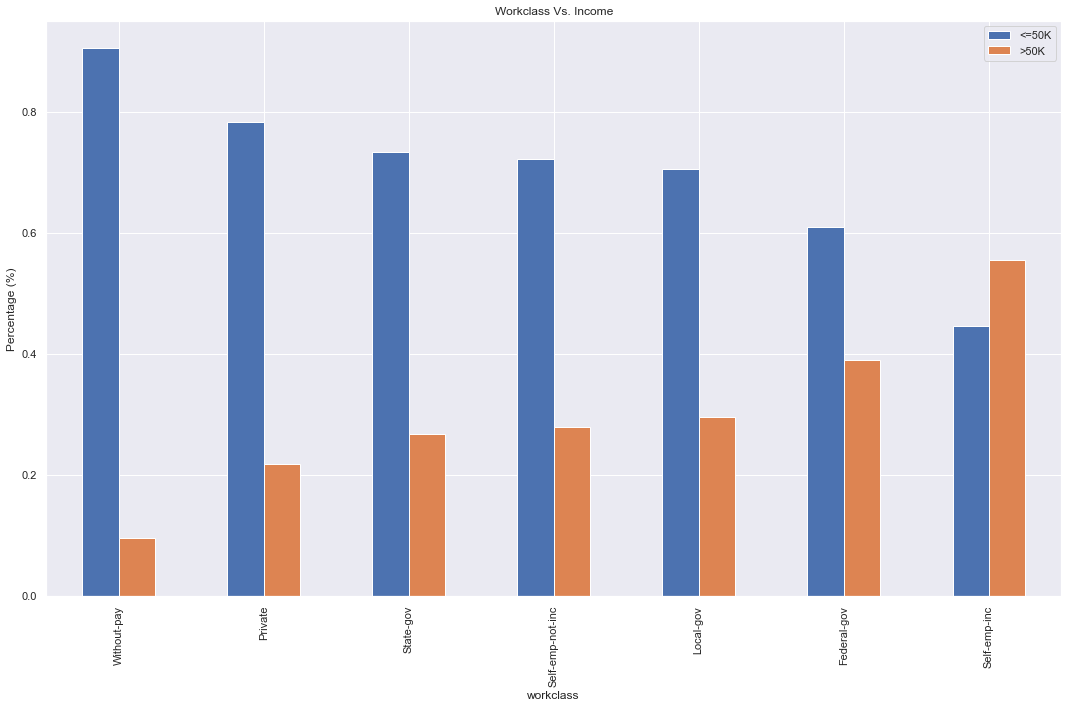

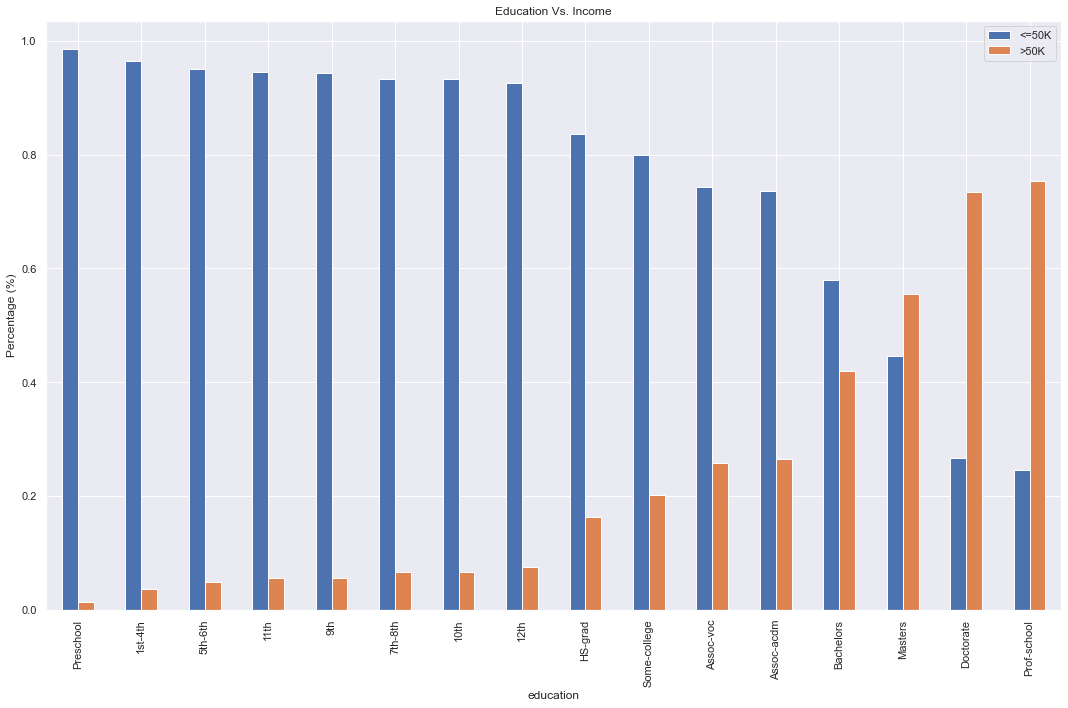

In [19]:
def getGroupPlot(df, columns=["workclass","income"], value = "income"):
    data = df.groupby(columns)[value].count().unstack()
    data = data.div(data.apply(sum,1),0)
    data.sort_values(by = 1, inplace = True)
    data.plot(kind="bar", 
              figsize=(15, 10), 
              title= (columns[0] + " vs. " + columns[1]).title(),
              ylabel = 'Percentage (%)')
    plt.legend(["<=50K", ">50K"])
    plt.tight_layout()
    plt.show()
    return data

# Bin hours per week into four categories for visualization purposes only
df.loc[df['hours-per-week'].between(0, 40, 'left'), 'hoursPerWeek'] = '<40'
df.loc[df['hours-per-week'].between(40, 60, 'left'), 'hoursPerWeek'] = '<60'
df.loc[df['hours-per-week'].between(60, 80, 'left'), 'hoursPerWeek'] = '<80'
df.loc[df['hours-per-week'].between(80, 100, 'both'), 'hoursPerWeek'] = '>=80'
catData = catData|{'hoursPerWeek'}

groupbyAll = {}
for i in catData:
    groupbyAll[i] = (getGroupPlot(df, columns=[i,"income"],value="income"))

# Drop hoursPerWeek & education for the remainder of the modeling since education-num gives the same information
# as education and hoursPerWeek were only used for visualization
df.drop(columns=["hoursPerWeek", "education"], inplace = True)
catData = catData - {'hoursPerWeek', 'education'}

## Data Transformation
This section prepares data for modeling includes: adjusting for skew, one hot encoding and normalization. I read online that it is **best practice to split the data BEFORE applying any transformations to the data.** Fit the transformations onto the training dataset and transform both the train and test dataset.

Reference:
* Preprocessing Data with SciKit: https://scikit-learn.org/stable/modules/preprocessing.html
    * This has all the necessary pacakges and techniques you would need to preprocess your data includng standardization, normalization, non-linear transformations such as mappinig to a gaussian (PowerTransformer), encoders, discretization, generating polynomial features, etc.
* https://machinelearningmastery.com/data-preparation-techniques-for-machine-learning/
    * Good discussion about general steps required for preparing data for modeling and when to do certain preparation over others depending on the model you plan to use

In [20]:
# Split data prior to transformations
X_train, X_test, y_train, y_test = train_test_split(df[list(set(df.columns)-{"income"})], df['income'], test_size=0.2, random_state=randomState)



<AxesSubplot:title={'center':'Numerical Data Before Transformation'}, ylabel='Numerical Value'>

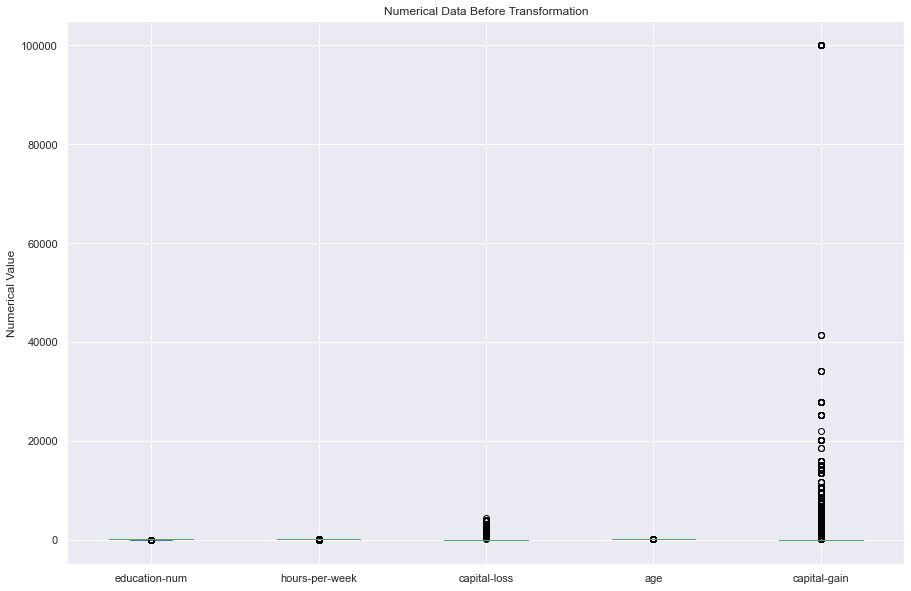

In [21]:
X_train[numData].plot(kind = 'box', 
                                 figsize = (15,10),
                                 title="Numerical Data Before Transformation",
                                xlabel = "Features",
                                ylabel="Numerical Value")

#### Skew
References:
* https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45
* https://yashowardhanshinde.medium.com/what-is-skewness-in-data-how-to-fix-skewed-data-in-python-a792e98c0fa6
* https://docs.oracle.com/cd/E57185_01/CBREG/ch03s02s03s01.html#:~:text=A%20skewness%20value%20greater%20than,the%20distribution%20is%20fairly%20symmetrical

In [22]:
# Skew value <-1 or >1 is highly skewed
X_train[numData].skew().sort_values(ascending=False)

capital-gain      11.957326
capital-loss       4.526028
age                0.530152
hours-per-week     0.316860
education-num     -0.304877
dtype: float64

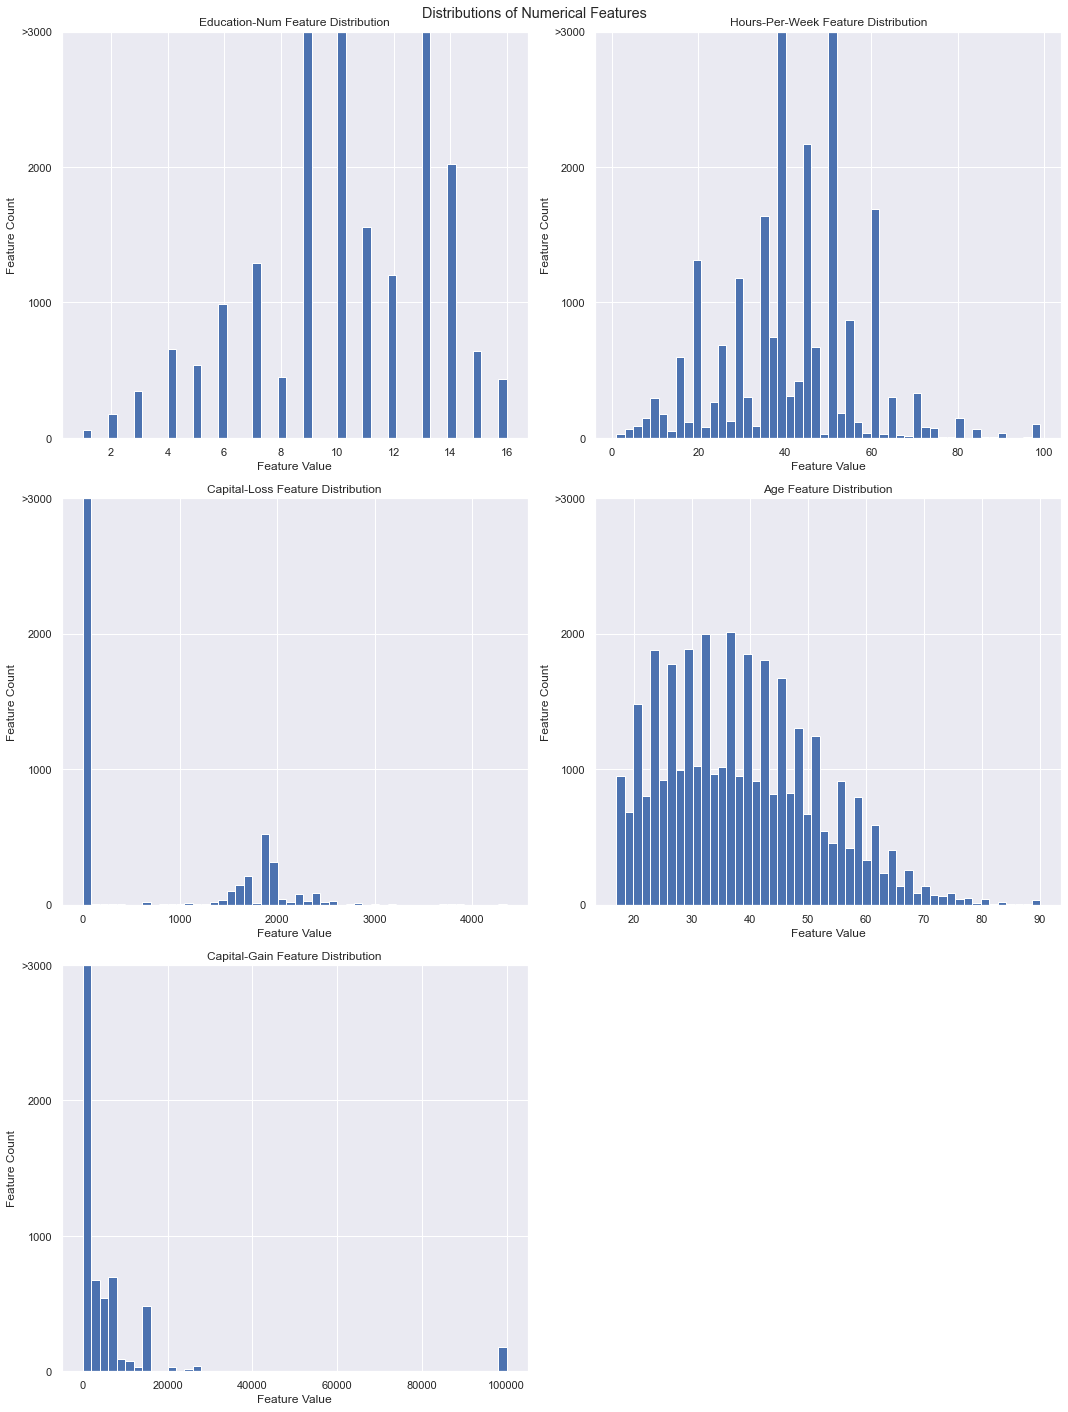

In [23]:
## Visualize Skewness
fig = plt.figure(figsize = (15,20));
for i, feature in enumerate(X_train[numData]):
    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(X_train[feature], bins = 50)
    ax.set_title(f"{feature.title()} Feature Distribution")
    ax.set_xlabel("Feature Value")
    ax.set_ylabel("Feature Count")
    ax.set_ylim((0, 3000))
    ax.set_yticks([0, 1000, 2000, 3000])
    ax.set_yticklabels([0, 1000, 2000, ">3000"])
fig.suptitle("Distributions of Numerical Features")
fig.tight_layout()
plt.show()

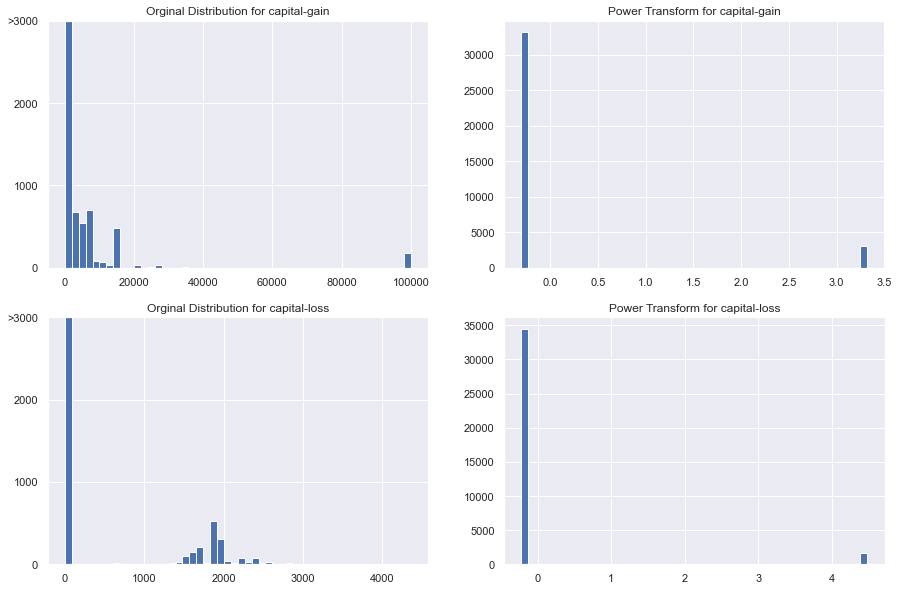

capital-loss      4.262664
capital-gain      3.019664
age               0.530152
hours-per-week    0.316860
education-num    -0.304877
dtype: float64

In [24]:
# Adjust for skewness on capital gain and capital loss
powerSkew = PowerTransformer()
fig = plt.figure(figsize=(15,10))

j = 1
for i in ["capital-gain","capital-loss"]:
    ax = fig.add_subplot(2, 2, j)
    ax.hist(X_train[i], bins = 50)
    ax.set_title(f"Orginal Distribution for {i}")
    ax.set_ylim((0, 3000))
    ax.set_yticks([0, 1000, 2000, 3000])
    ax.set_yticklabels([0, 1000, 2000, ">3000"])
    j+=2

powerSkew = PowerTransformer()
X_train[['capital-gain','capital-loss']]=powerSkew.fit_transform(X_train[['capital-gain','capital-loss']])
X_test[['capital-gain','capital-loss']] = powerSkew.transform(X_test[['capital-gain','capital-loss']])

j=2
for i in ["capital-gain","capital-loss"]: 
    ax = fig.add_subplot(2, 2, j)
    ax.hist(X_train[i], bins = 50)
    ax.set_title(f"Power Transform for {i}")
    j += 2

plt.show()
X_train[numData].skew().sort_values(ascending=False)

In [25]:
X_train.head(5)

,relationship,race,education-num,hours-per-week,marital-status,occupation,capital-loss,age,native-country,sex,workclass,capital-gain
18640,Not-in-family,Black,9.0,40.0,Never-married,Adm-clerical,-0.222944,43,United-States,Female,Private,-0.301143
32104,Husband,Black,9.0,60.0,Married-civ-spouse,Exec-managerial,-0.222944,26,United-States,Male,Private,-0.301143
15793,Wife,White,10.0,40.0,Married-civ-spouse,Exec-managerial,-0.222944,54,United-States,Female,Local-gov,-0.301143
22349,Own-child,White,9.0,40.0,Never-married,Machine-op-inspct,-0.222944,21,United-States,Male,Private,-0.301143
11968,Unmarried,White,10.0,40.0,Divorced,Adm-clerical,-0.222944,25,United-States,Female,Private,-0.301143


#### Normalization
Reference:
* When to Normalize vs. Standardize? https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
    * Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.
    * Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

<AxesSubplot:title={'center':'Numerical Data After Skew Transformation'}, ylabel='Numerical Value'>

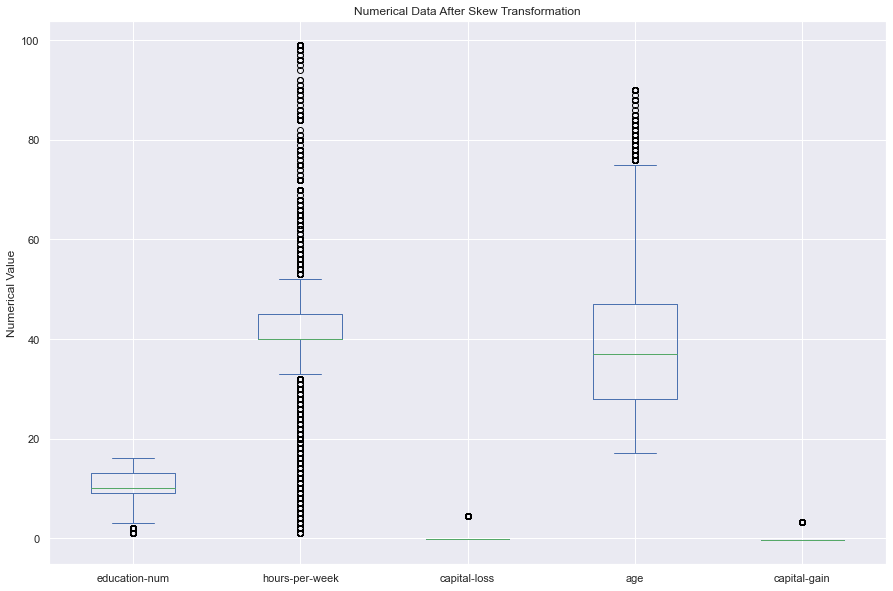

In [26]:
X_train[numData].plot(kind = 'box', 
                                 figsize = (15,10),
                                 title="Numerical Data After Skew Transformation",
                                xlabel = "Features",
                                ylabel="Numerical Value")

In [27]:
## Because I know the capital loss and capital-gain do not follw a normal distribution still, I am
## choosing to normalize all the numerical data rather than standardize
normalize = MinMaxScaler()
X_train[numData] = normalize.fit_transform(X_train[numData])
X_test[numData] = normalize.transform(X_test[numData])
X_train.head(5)

,relationship,race,education-num,hours-per-week,marital-status,occupation,capital-loss,age,native-country,sex,workclass,capital-gain
18640,Not-in-family,Black,0.533333,0.397959,Never-married,Adm-clerical,0.0,0.356164,United-States,Female,Private,0.0
32104,Husband,Black,0.533333,0.602041,Married-civ-spouse,Exec-managerial,0.0,0.123288,United-States,Male,Private,0.0
15793,Wife,White,0.600000,0.397959,Married-civ-spouse,Exec-managerial,0.0,0.506849,United-States,Female,Local-gov,0.0
22349,Own-child,White,0.533333,0.397959,Never-married,Machine-op-inspct,0.0,0.054795,United-States,Male,Private,0.0
11968,Unmarried,White,0.600000,0.397959,Divorced,Adm-clerical,0.0,0.109589,United-States,Female,Private,0.0


<AxesSubplot:title={'center':'Numerical Data After Normalization'}, ylabel='Numerical Value'>

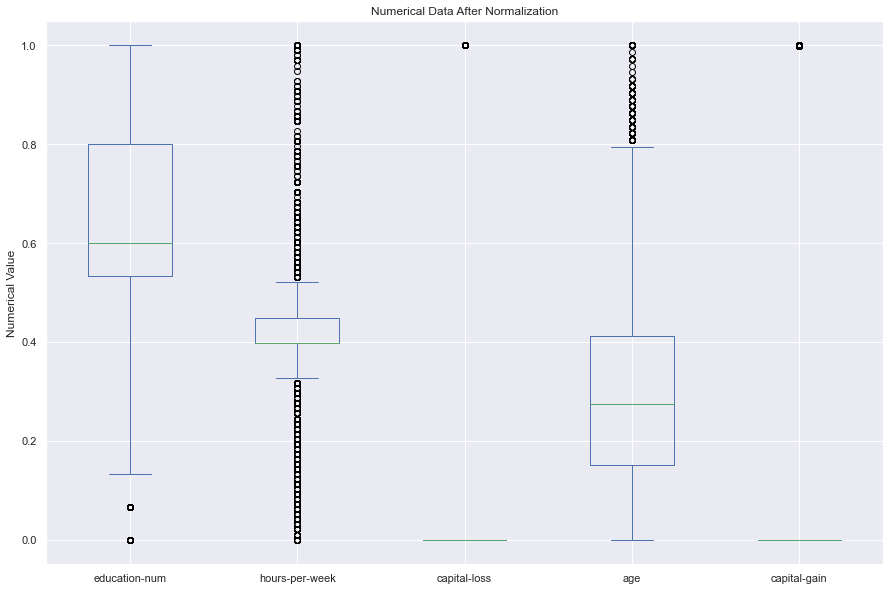

In [28]:
# Used to identify if normalization is required
X_train[numData].plot(kind = 'box', 
                                 figsize = (15,10),
                                 title="Numerical Data After Normalization",
                                xlabel = "Features",
                                ylabel="Numerical Value")

#### One-hot encoding
Reference: 
* OneHotEncoding vs. GetDummies: https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
    * Generally, For machine learning, you almost definitely want to use sklearn.OneHotEncoder. For other tasks like simple analyses, you might be able to use pd.get_dummies, which is a bit more convenient.
    * sklearn encoder creates a function which **persists** and can then be applied to new data sets which use the same categorical variables, with consistent results.
    * Use OHE b/c A categorical feature containing values that appear in the test set but not the training set
    * Use OHE b/b A categorical feature in the test set containing a subset of the total possible values
* How to OneHotEncode on Multi-Columns and Preserve Index https://stackoverflow.com/questions/50414823/how-to-keep-columns-names-after-one-hot-encoding-sklearn
* OHE and dropping a variable to reduce multicolinearity - https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding & https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn
    * Note: Dummy and OHE are different processes. Dummy will drop a varaiable that is redundant while OHE doesn't. From some readings, it is stated that if using OHE, you should drop the intercept within your model. 

Question:
* For modeling, will it depend on the index or does index not matter and order matter more? 
* Still would like clarification about when and when not to delete redundant encoded columns and when to include and not include an intercept

In [29]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_trainCat = pd.DataFrame(encoder.fit_transform(X_train[catData]))
X_testCat = pd.DataFrame(encoder.transform(X_test[catData]))

# Grab index location of categorical data to pass get_feature_names
catIdx = [X_train.columns.get_loc(col) for col in catData]

# Adding column names to the encoded data set
X_trainCat.columns = encoder.get_feature_names(X_train.columns.values[catIdx].tolist())
X_testCat.columns = encoder.get_feature_names(X_train.columns.values[catIdx].tolist())

# One-hot encoding removed index; put it back
X_trainCat.index = X_train.index
X_testCat.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
X_trainNum = X_train.drop(catData, axis=1)
X_testNum = X_test.drop(catData, axis=1)

# Add one-hot encoded columns to numerical features
X_train2 = pd.concat([X_trainNum, X_trainCat], axis=1)
X_test2 = pd.concat([X_testNum, X_testCat], axis=1)

/var/folders/lg/9fhjsjp14vz2kyr4qqk41t7m0000gn/T/ipykernel_59260/3565315877.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_trainCat = pd.DataFrame(encoder.fit_transform(X_train[catData]))
/var/folders/lg/9fhjsjp14vz2kyr4qqk41t7m0000gn/T/ipykernel_59260/3565315877.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_testCat = pd.DataFrame(encoder.transform(X_test[catData]))
/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; ge

In [30]:
X_test2

,education-num,hours-per-week,capital-loss,age,capital-gain,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,...,native-country_Yugoslavia,sex_Female,sex_Male,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay
22560,0.600000,0.234694,0.0,0.054795,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19780,0.733333,0.346939,0.0,0.630137,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15205,0.533333,0.377551,0.0,0.602740,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4404,0.600000,0.397959,0.0,0.410959,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18140,0.533333,0.602041,0.0,0.273973,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13265,0.533333,0.418367,0.0,0.356164,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11982,0.066667,0.397959,0.0,0.246575,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13236,0.533333,0.397959,1.0,0.547945,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14362,0.533333,0.397959,0.0,0.479452,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Dimensionality Reduction
This section focuses on dimensionality reduction: random forest analysis, pca, svd

#### Single Value Decomposition Analysis
Using SVD to determine the number of features requried to explain a specific threshold of variance. Note that in some models, they use the transformed data moving forward as part of their preprocessing pipeline

Reference:
* http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

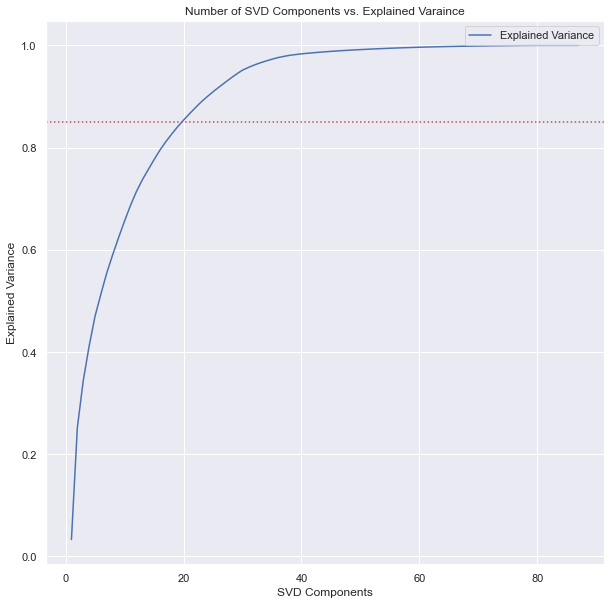

SVD suggest that there should be at least 20 of 87 SVD components
to provide 85.0% variance


In [401]:
svdThresh = 0.85
svdVar = []
for i in range(1,len(X_train2.columns)+1):
    svdVar.append({"n_components":i, "explainedVar":sum(TruncatedSVD(n_components = i).fit(X_train2).explained_variance_ratio_)})
svdVar = pd.DataFrame(svdVar)

plt.figure(figsize=(10,10))
plt.plot(svdVar['n_components'], svdVar['explainedVar'], label = 'Explained Variance')
plt.axhline(y = svdThresh, color = 'r', linestyle = ':')
plt.legend()
plt.xlabel("SVD Components")
plt.ylabel("Explained Variance")
plt.title("Number of SVD Components vs. Explained Varaince")
plt.show()

print(f"SVD suggest that there should be at least {svdVar[svdVar['explainedVar']>=svdThresh].iloc[0]['n_components']:0.0f} of {len(svdVar)} SVD components\n\
to provide {svdThresh*100}% variance")



#### PCA
Question:
* What should the threshold for explained varance ratio be? Always 90%?
* Do people make models using the PCA components rather than inferring information from it (i.e. you should focus on X features to contain Y% variance)
* SVD vs. PCA?

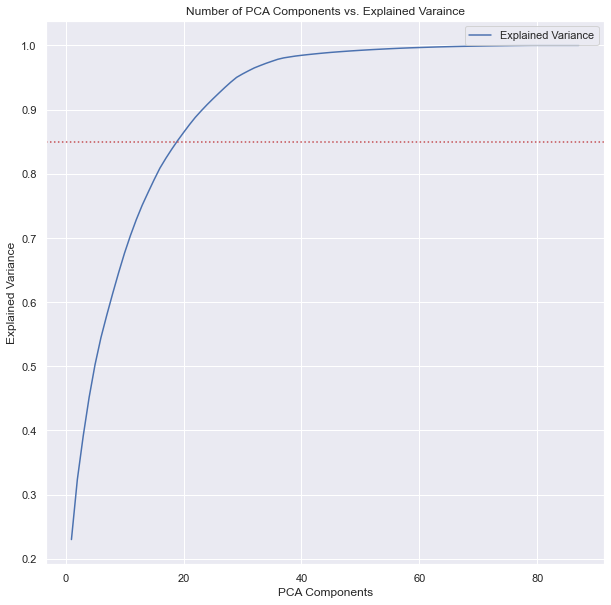

PCA suggest that there should be at least 19 of 87 PCA components
to provide 85.0% variance


In [400]:
pcaThresh = 0.85
pcaVar = []
for i in range(1,len(X_train2.columns)+1):
    pcaVar.append({"n_components":i, "explainedVar":sum(PCA(n_components = i).fit(X_train2).explained_variance_ratio_)})
pcaVar = pd.DataFrame(pcaVar)

plt.figure(figsize=(10,10))
plt.plot(pcaVar['n_components'], pcaVar['explainedVar'], label = 'Explained Variance')
plt.axhline(y = pcaThresh, color = 'r', linestyle = ':')
plt.legend()
plt.xlabel("PCA Components")
plt.ylabel("Explained Variance")
plt.title("Number of PCA Components vs. Explained Varaince")
plt.show()

print(f"PCA suggest that there should be at least {pcaVar[pcaVar['explainedVar']>=pcaThresh].iloc[0]['n_components']:0.0f} of {len(pcaVar)} PCA components\n\
to provide {pcaThresh*100}% variance")



#### Random Forest Feature Analysis
Reference:
* https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/

Questions:
* Same as PCA, how do we know what threshold to focus on when selecting features?
* Is HyperTuning the parameters generally recommended for feature reduction? 
* Do people generally conduct feature reduction with Random Forest and then recreate another random forest using the selected features from the original results?

Using various thresholds to determine accuracy of logistic regression

In [31]:
thresh = [0.001,0.005,0.0075, 0.01,0.05,0.1]
threshFeatures = {}
rfAnalysis = RandomForestClassifier(random_state=randomState).fit(X_train2, y_train)
X_train2_FeatureImportance = pd.DataFrame(rfAnalysis.feature_importances_, X_train2.columns).round(4).sort_values(by=[0], ascending=False)
for i in thresh:
    print("===========================")
    threshCol = list(X_train2_FeatureImportance[X_train2_FeatureImportance[0]>i].index)
    threshFeatures[str(i)] = threshCol
    logThresh = LogisticRegression(random_state=randomState)
    logThresh = logThresh.fit(X_train2[threshCol], y_train)
    print(f"\nNumber of features selected: {len(threshCol)}")
    print(f"\nFeatures include {threshCol}")
    print(f"\nRandom Forest Top {i} Threshold, Accuracy for Logistic Regression: {accuracy_score(y_test, logThresh.predict(X_test2[threshCol])):0.3f}")


/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Number of features selected: 44

Features include ['age', 'education-num', 'hours-per-week', 'capital-gain', 'marital-status_Married-civ-spouse', 'relationship_Husband', 'marital-status_Never-married', 'occupation_Exec-managerial', 'occupation_Prof-specialty', 'capital-loss', 'relationship_Not-in-family', 'workclass_Private', 'relationship_Wife', 'sex_Male', 'occupation_Other-service', 'relationship_Own-child', 'sex_Female', 'workclass_Self-emp-not-inc', 'marital-status_Divorced', 'relationship_Unmarried', 'workclass_Self-emp-inc', 'occupation_Sales', 'occupation_Craft-repair', 'race_White', 'workclass_Local-gov', 'native-country_United-States', 'occupation_Adm-clerical', 'occupation_Farming-fishing', 'workclass_Federal-gov', 'race_Black', 'occupation_Tech-support', 'occupation_Transport-moving', 'workclass_State-gov', 'occupation_Machine-op-inspct', 'occupation_Handlers-cleaners', 'race_Asian-Pac-Islander', 'occupation_Protective-serv', 'native-country_Mexico', 'relationship_Other-re

/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Number of features selected: 29

Features include ['age', 'education-num', 'hours-per-week', 'capital-gain', 'marital-status_Married-civ-spouse', 'relationship_Husband', 'marital-status_Never-married', 'occupation_Exec-managerial', 'occupation_Prof-specialty', 'capital-loss', 'relationship_Not-in-family', 'workclass_Private', 'relationship_Wife', 'sex_Male', 'occupation_Other-service', 'relationship_Own-child', 'sex_Female', 'workclass_Self-emp-not-inc', 'marital-status_Divorced', 'relationship_Unmarried', 'workclass_Self-emp-inc', 'occupation_Sales', 'occupation_Craft-repair', 'race_White', 'workclass_Local-gov', 'native-country_United-States', 'occupation_Adm-clerical', 'occupation_Farming-fishing', 'workclass_Federal-gov']

Random Forest Top 0.005 Threshold, Accuracy for Logistic Regression: 0.840

Number of features selected: 18

Features include ['age', 'education-num', 'hours-per-week', 'capital-gain', 'marital-status_Married-civ-spouse', 'relationship_Husband', 'marital-status_

In [39]:
print("Because PCA, SVD suggest 18-20 features of 87 to cover 85% variance and the Random Forest Analysis\n\
suggest 14-28 features with feature importance threshold of 0.005-0.01, I will select threshold 0.0075.\n\
At 0.0075, this meets the PCA/SVD variance coverage and minimizes the feature space significantly without\n\
diminishing the accuracy of a logistic regression. Although 5-14 features still produces a great accuracy\n\
according to PCA/SVD, reducing the feature space this much would reduce variance coverage.")

Because PCA, SVD suggest 18-20 features of 87 to cover 85% variance and the Random Forest Analysis
suggest 14-28 features with feature importance threshold of 0.005-0.01, I will select threshold 0.0075.
At 0.0075, this meets the PCA/SVD variance coverage and minimizes the feature space significantly without
diminishing the accuracy of a logistic regression. Although 5-14 features still produces a great accuracy
according to PCA/SVD, reducing the feature space this much would reduce variance coverage.


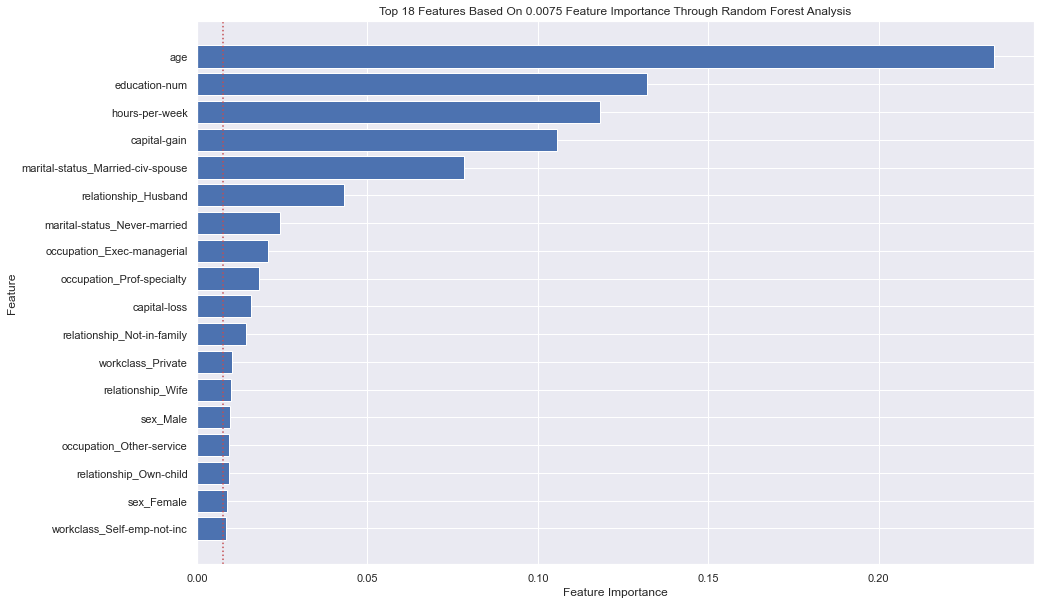

In [32]:
X_train2_FeatureImportance = X_train2_FeatureImportance[X_train2_FeatureImportance[0]>0.0075].sort_values(by=[0], ascending=True)
plt.figure(figsize=(15,10))
plt.barh(range(len(X_train2_FeatureImportance)), X_train2_FeatureImportance[0]) 
plt.yticks(range(len(X_train2_FeatureImportance)), X_train2_FeatureImportance.index) 
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.axvline(x = 0.0075, color = 'r', linestyle = ':')
plt.title(f"Top {len(X_train2_FeatureImportance)} Features Based On 0.0075 Feature Importance Through Random Forest Analysis")
plt.show()

In [33]:
X_train3 = X_train2[list(X_train2_FeatureImportance.index)]
X_test3 = X_test2[list(X_train2_FeatureImportance.index)]

## Covariance Matrix & Correlation Matrix
Correlation is essentially covariance but normalized using the standard deviation of both variables. Therefore, the result will be between -1,1 with -1 implying that two varables are perfectly negatively correlated and vice versa for +1. Both covariance and correlation of 0 signify that there is no relationship between the two variables. Therefore, the diagonal of the correlation matrix is always one because you're essentially dividing the variance^2 by variance^2 

Reference: 
* https://www.mygreatlearning.com/blog/covariance-vs-correlation/

#### Covariance matrix

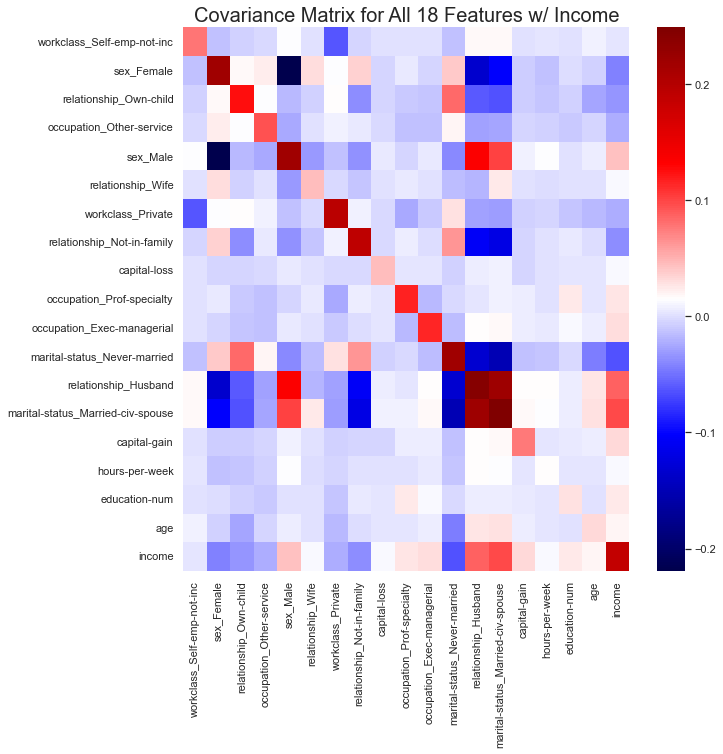

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.concat([X_train3, y_train], axis=1).cov(), annot=False, cmap="seismic")
plt.title(f"Covariance Matrix for All {len(X_train3.columns)} Features w/ Income",  fontsize=20)
plt.show()

#### Correlation Matrix

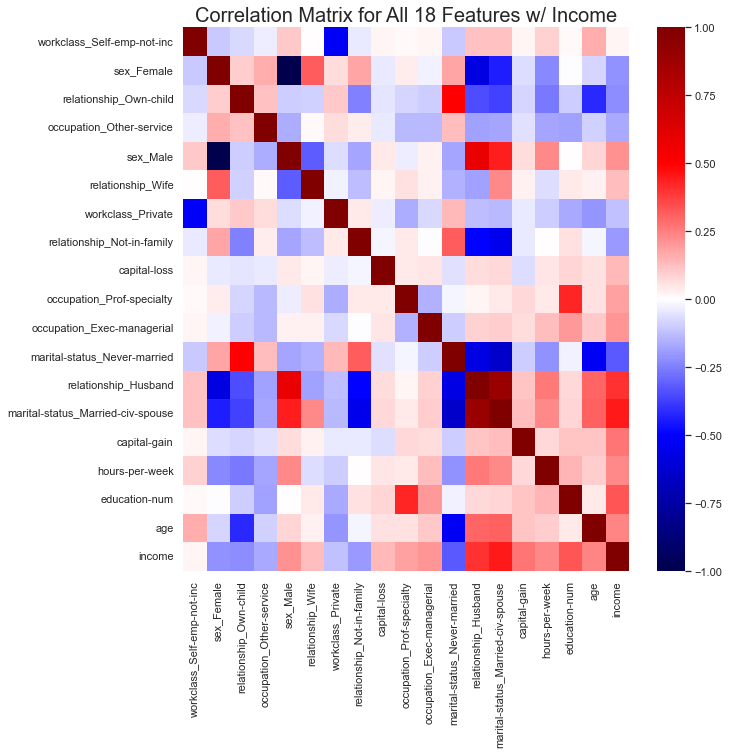

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.concat([X_train3, y_train], axis=1).corr(method='pearson'), annot=False, cmap="seismic")
plt.title(f"Correlation Matrix for All {len(X_train3.columns)} Features w/ Income",  fontsize=20)
plt.show()

# Phase II: Regression Analysis

### Logistic Regression Analysis
Results from sms.logit summary report:
* ~Obtain a base model~
* Confidence interval analysis

Feature Selection:
* ~T-test analysis~
* ~F-test analysis~
* ~Stepwise regression analysis~
* ~Collinearity analysis~
    * Threshold for Variance Inflation Factor, suggestions on how to handle, and when to high VIF can be overlooked 
        * https://corporatefinanceinstitute.com/resources/data-science/variance-inflation-factor-vif/

Reference:
* https://investigate.ai/regression/evaluating-logistic-regressions/
    * LLR p-value (for model) & P>|z| (for features) - Typically a p value of 0.05 (or 5%) is thought of as "good" or "statistically significant," as there's only a 5% or less chance that these results aren't valid.
* https://www.statology.org/f-test-python/
    * F-test tells us: Do two samples come from populations with equal variances?

#### T-test and F-test

In [83]:
tTest = []
fTest = []
alpha = 0.05

for i in range(len(X_train3.columns)):
    for k in range(i+1, len(X_train3.columns)):
        iCol = X_train3.columns[i]
        kCol = X_train3.columns[k]
        
        ## f test
        f = np.var(X_train3[iCol], ddof=1)/np.var(X_train3[kCol], ddof=1)
        f_pvalue = 1-scipy.stats.f.cdf(f, X_train3[iCol].size-1, X_train3[kCol].size-1)
        if f_pvalue <= alpha:
            fTest.append({"feature1":iCol, "feature2":kCol, "f-test":f, "p-value":f_pvalue})
        
        ## t test
        tResults = ttest_ind(X_train3[iCol], X_train3[kCol])
        if tResults.pvalue <= alpha:
            tTest.append({"feature1":iCol, "feature2":kCol, "t-test":tResults.statistic, "p-value":tResults.pvalue})
tTest = pd.DataFrame(tTest).round(3)
fTest = pd.DataFrame(fTest).round(2)
display(tTest.sort_values(by=["t-test"],ascending=False))


,feature1,feature2,t-test,p-value
85,workclass_Private,capital-loss,268.048,0.0
147,education-num,age,239.226,0.0
91,workclass_Private,capital-gain,239.048,0.0
60,sex_Male,relationship_Wife,233.196,0.0
63,sex_Male,capital-loss,232.281,0.0
...,...,...,...,...
81,relationship_Wife,hours-per-week,-283.039,0.0
14,workclass_Self-emp-not-inc,education-num,-304.916,0.0
143,capital-gain,education-num,-307.838,0.0
112,capital-loss,education-num,-391.887,0.0


In [82]:
fTest.sort_values(by=["f-test"],ascending=False)

,feature1,feature2,f-test,p-value
80,marital-status_Married-civ-spouse,hours-per-week,16.67,0.00
76,relationship_Husband,hours-per-week,16.24,0.00
15,sex_Female,hours-per-week,14.69,0.00
40,sex_Male,hours-per-week,14.69,0.00
72,marital-status_Never-married,hours-per-week,14.64,0.00
...,...,...,...,...
34,sex_Male,workclass_Private,1.13,0.00
9,sex_Female,workclass_Private,1.13,0.00
22,relationship_Own-child,occupation_Exec-managerial,1.09,0.00
21,relationship_Own-child,occupation_Prof-specialty,1.08,0.00


# TODO - "TALK ABOUT CONFIDENCE INTERVAL"


#### Colinearity Assessment using VIF

In [48]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train3.columns 
vif_scores["vifScores"] = [variance_inflation_factor(X_train3.values, i) for i in range(len(X_train3.columns))] 
# display(vif_scores.sort_values(by=['vifScores'], ascending =False))
print("It is known that colinearity will exist with binary one hot encoded features such as male and female.\n\
However upon reseearch, it suggest this analysis can be ignored for said features and instead ensure\n\
when modeling a regression to exclude the intercept. Similar information can be made for husband/wife.\n\
It might make sense to remove Married Civilian Spouse since Married-spouse-absent and Married-AF-spouse\n\
have been removed earlier and can infer this info from relationship (husband/wife). However for the\n\
remainder of the modeling, will leave feature space as is.")

vif_scores2 = pd.DataFrame() 
tempCol = set(X_train3.columns) - {"marital-status_Married-civ-spouse"}
vif_scores2["Attribute"] = list(tempCol)
vif_scores2["vifScores"] = [variance_inflation_factor(X_train3[list(tempCol)].values, i) for i in range(len(tempCol))]
display(vif_scores.merge(vif_scores2, on="Attribute", how="left", suffixes=("_original","_updated")).round(2).sort_values(by=['vifScores_original'], ascending =False))



It is known that colinearity will exist with binary one hot encoded features such as male and female.
However upon reseearch, it suggest this analysis can be ignored for said features and instead ensure
when modeling a regression to exclude the intercept. Similar information can be made for husband/wife.
It might make sense to remove Married Civilian Spouse since Married-spouse-absent and Married-AF-spouse
have been removed earlier and can infer this info from relationship (husband/wife). However for the
remainder of the modeling, will leave feature space as is.


,Attribute,vifScores_original,vifScores_updated
4,sex_Male,36.61,36.19
13,marital-status_Married-civ-spouse,31.94,NaN
12,relationship_Husband,31.48,3.73
1,sex_Female,16.20,16.07
5,relationship_Wife,6.44,1.37
11,marital-status_Never-married,2.44,2.38
7,relationship_Not-in-family,2.37,2.36
2,relationship_Own-child,2.24,2.24
17,age,1.54,1.53
6,workclass_Private,1.45,1.45


#### Backwards Stepwise Regression To Reduce Feature Selection Further

In [41]:
def backwardStepwise(X_train, y_train, X_test, y_test, thresh = 0.05):
    features=list(X_train.columns)
    while True:
        changed=False
        model = sm.Logit(y_train, sm.add_constant(X_train[features])).fit()
        pvalues = model.pvalues.iloc[1:]
        if pvalues.max() > thresh:
            changed=True
            features.remove(pvalues.idxmax())
            print(f'Feature "{pvalues.idxmax()}" dropped (p-value {pvalues.max():.2f} > thresh {thresh})')
        if not changed:
            break
    print(f"\nFeatures kept by backwards stepwise regression are: {', '.join(features)}")
    return features, accuracy_score(y_test, model.predict(sm.add_constant(X_test[features])).round())


features, accuracy = backwardStepwise(X_train3, y_train, X_test3, y_test, thresh=0.05)
print(f"\nAccuracy: {accuracy:0.3f}\n")
print("\nBecause there are no real accuraccy gains after stepwise regression, choosing to leave feature space as is.")



Optimization terminated successfully.
         Current function value: 0.344836
         Iterations 8
Feature "sex_Male" dropped (p-value 1.00 > thresh 0.05)
Optimization terminated successfully.
         Current function value: 0.344836
         Iterations 8
Feature "workclass_Private" dropped (p-value 0.30 > thresh 0.05)
Optimization terminated successfully.
         Current function value: 0.344851
         Iterations 8

Features kept by backwards stepwise regression are: workclass_Self-emp-not-inc, sex_Female, relationship_Own-child, occupation_Other-service, relationship_Wife, relationship_Not-in-family, capital-loss, occupation_Prof-specialty, occupation_Exec-managerial, marital-status_Never-married, relationship_Husband, marital-status_Married-civ-spouse, capital-gain, hours-per-week, education-num, age

Accuracy: 0.837


Because there are no real accuraccy gains after stepwise regression, choosing to leave feature space as is.


### Final Logistic Regression

In [39]:
log1Stats = sm.Logit(y_train, sm.add_constant(X_train3)).fit()
print(log1Stats.summary())

log1SciKit = LogisticRegression(random_state=randomState, fit_intercept=False)
log1SciKit = log1SciKit.fit(X_train3, y_train)

print(f"Accuracy for StatsModel: {accuracy_score(y_test, log1Stats.predict(sm.add_constant(X_test3)).round()):0.3f}")
print(f"Accuracy for SciKit: {accuracy_score(y_test, log1SciKit.predict(X_test3)):0.3f}")

Optimization terminated successfully.
         Current function value: 0.344836
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                36177
Model:                          Logit   Df Residuals:                    36159
Method:                           MLE   Df Model:                           17
Date:                Sat, 10 Dec 2022   Pseudo R-squ.:                  0.3854
Time:                        17:53:38   Log-Likelihood:                -12475.
converged:                       True   LL-Null:                       -20298.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -5.1425   6.31e+05  -8.15

# Phase III: Model Curation

**Types:**
* Logistic regression
* Decision tree
* KNN
* SVM
* Naïve Bayes

**References:**


**Questions:**
* How do you know which Naive Bayes model to use? Gaussian, categorical, etc.?


## Base Models

#### Train Base Models

In [68]:
def classifierEval(clf, X_train, y_train, X_test, y_test): 
    results = {}
    
    start = time()
    clf = clf.fit(X_train, y_train)
    results['train_time'] = time() - start
    
    start = time()
    pred = clf.predict(X_test)
    results['pred_time'] = time() - start
    
    confusion = confusion_matrix(y_test,pred).ravel()
    tn, fp, fn, tp = confusion 
    
    results['confusion'] = confusion
    results['accuracy'] =  accuracy_score(y_test,pred)
    results['precision'] = precision_score(y_test, pred)
    results['recall'] = recall_score(y_test,pred)
    results['f_measure'] = f1_score(y_test,pred)
    results['specificity'] = tn/(tn+fp)
    
    return clf, results

In [69]:
clf_Log = log1SciKit
clf_DTree = tree.DecisionTreeClassifier(random_state = randomState)
clf_KNN = KNeighborsClassifier(n_neighbors=3)
clf_SVM = svm.SVC(random_state = randomState)
clf_Bayes = GaussianNB()

# Collect results on the learners
results = {}
for clf in [clf_Log, clf_DTree, clf_KNN, clf_SVM, clf_Bayes]:
    print(clf.__class__.__name__)
    clf, results[clf.__class__.__name__] = classifierEval(clf, X_train3, y_train, X_test3, y_test)

LogisticRegression
DecisionTreeClassifier
KNeighborsClassifier
SVC
GaussianNB


#### Base Model Metrics

/var/folders/lg/9fhjsjp14vz2kyr4qqk41t7m0000gn/T/ipykernel_59260/1895103236.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  baseResults = baseResults.append(pd.DataFrame([colors], index=["colors"], columns=baseResults.columns))


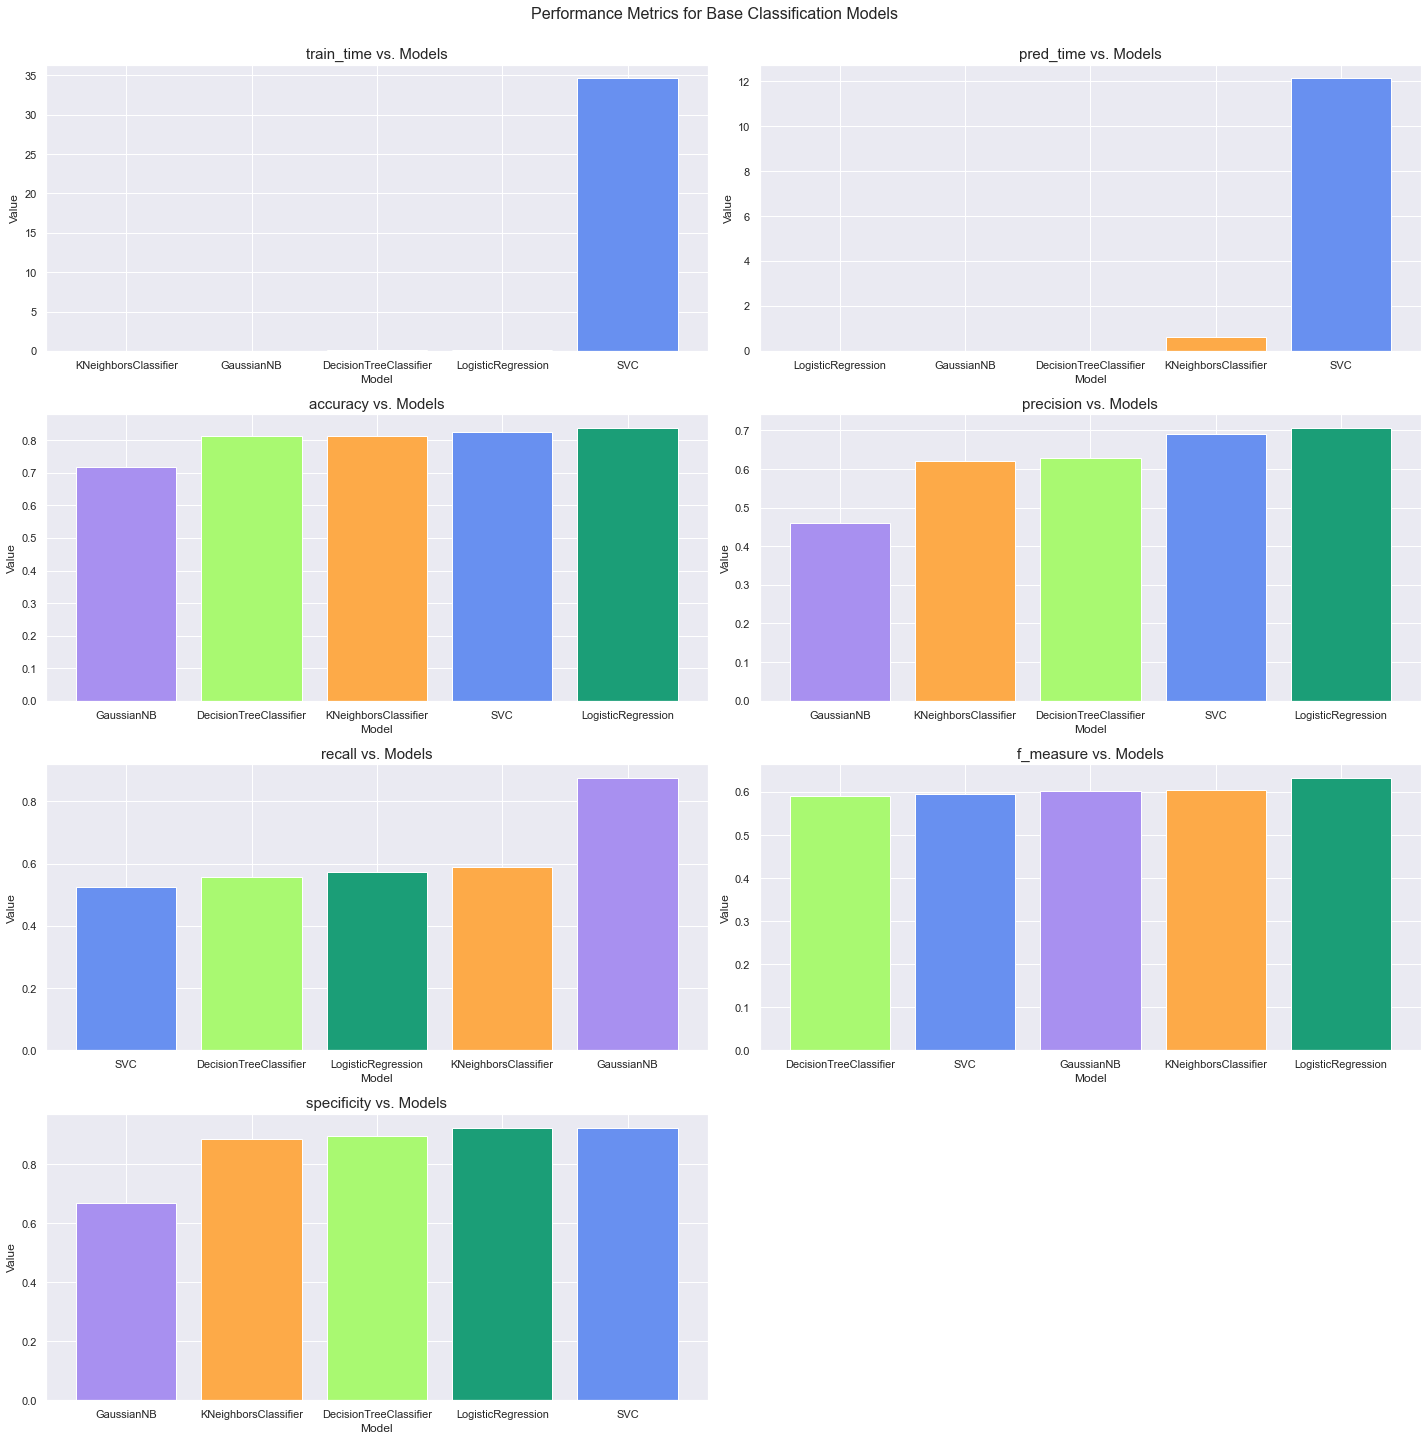

In [70]:
colors = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0']
baseResults = pd.DataFrame(results)
baseResults = baseResults.append(pd.DataFrame([colors], index=["colors"], columns=baseResults.columns))

fig = plt.figure(figsize=(20,20))
for j, label in enumerate(["train_time","pred_time","accuracy","precision","recall","f_measure","specificity"]):
    ax = fig.add_subplot(4, 2, j+1)
    temp = baseResults.sort_values(by=[label], axis=1)
    ax.bar(temp.loc[label].index, temp.loc[label].values, color = list(temp.loc["colors"]))
    ax.set_title(f"{label} vs. Models", fontsize=15)
    ax.set_xlabel("Model")
    ax.set_ylabel("Value")
plt.suptitle("Performance Metrics for Base Classification Models", fontsize = 16, y = 1)
plt.tight_layout()
plt.show()



In [71]:
baseResults.loc[list(set(baseResults.index) - {"colors","confusion"})].T.round(2)

,precision,recall,pred_time,train_time,specificity,accuracy,f_measure
LogisticRegression,0.706145,0.573243,0.001146,0.155181,0.923099,0.837811,0.632791
DecisionTreeClassifier,0.629668,0.558277,0.003749,0.077931,0.894152,0.812272,0.591827
KNeighborsClassifier,0.621881,0.587755,0.62294,0.005439,0.884795,0.812383,0.604337
SVC,0.690107,0.52517,12.127923,34.629835,0.923977,0.826755,0.596446
GaussianNB,0.460291,0.875283,0.002755,0.011323,0.669152,0.719403,0.603314


#### ROC and AUC for Base Models

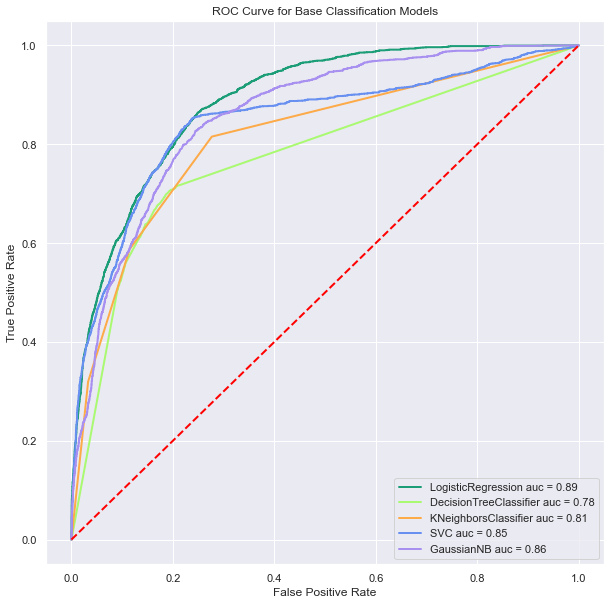

In [372]:
fig = plt.figure(figsize=(10,10))
for i, clf in enumerate([clf_Log, clf_DTree, clf_KNN, clf_SVM, clf_Bayes]):
        if clf.__class__.__name__ == "SVC":
            fpr, tpr, _ = roc_curve(y_test, clf.decision_function(X_test3))
        else:
            fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test3)[:,1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i],lw=2, label=f'{clf.__class__.__name__} auc = {roc_auc:.2f}')
    
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Base Classification Models')
plt.legend()
plt.show()

#### Confusion Matrix for Base Models

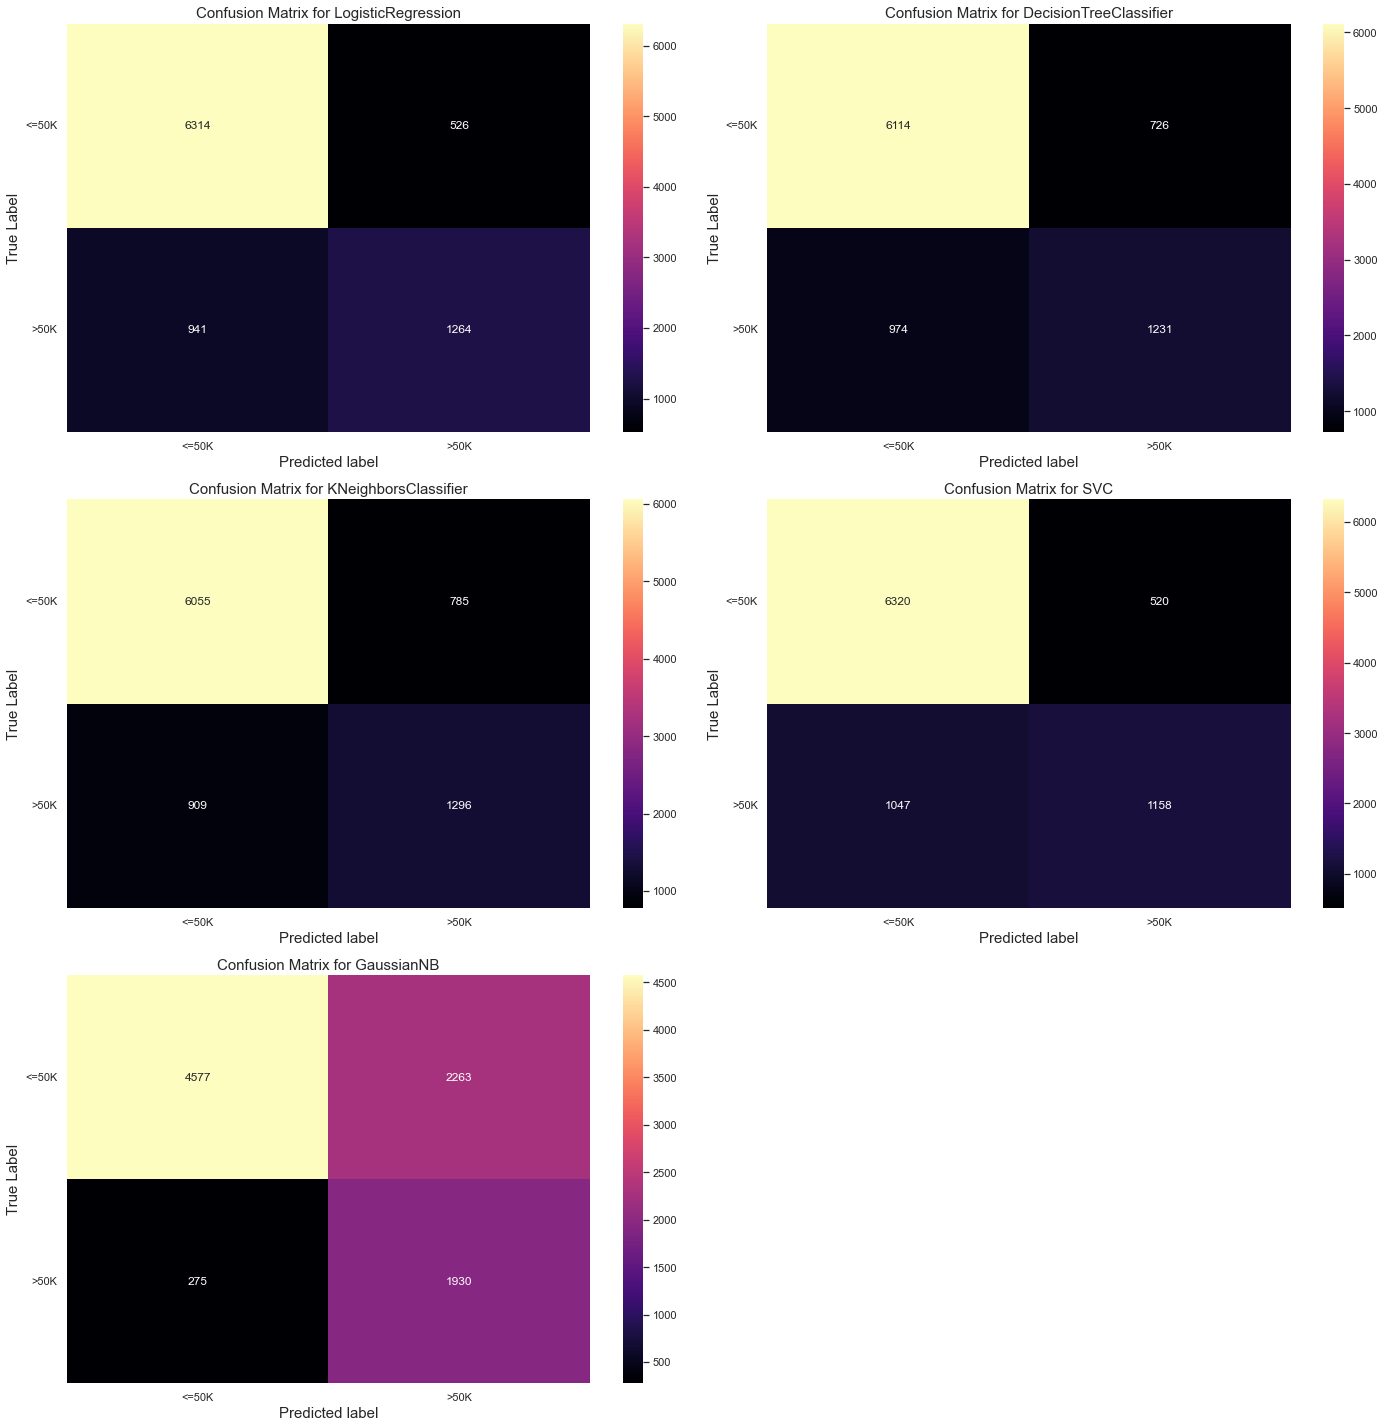

In [467]:
fig = plt.figure(figsize=(20,20))
j=0
for index, value in baseResults.loc['confusion'].iteritems():
    ax = fig.add_subplot(3, 2, j+1)
    sns.heatmap(value.reshape(2, -1), annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_xlabel("Predicted label", fontsize =15)
    ax.set_xticklabels(["<=50K",">50K"])
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_yticklabels(["<=50K",">50K"], rotation = 0)
    ax.set_title(f"Confusion Matrix for {index}", fontsize=15)
    j+=1
    
plt.tight_layout()
plt.show()

## Optimized Model w/ HyperTuning

Beacuse the GaussianNB performed poorly in the base model, will not consider it as a model for continued tuning. Logistic Regression was considered tuned from phase II. So the following models will be optmimized
* DecisionTree
* Support Vector Machine
* KNN

Question:
* How do you choose the best GridSearch parameters? Scoring? etc.

Reference:
* GridSearch.predict() == GridSearch.best_estmiator_.predict() - https://stackoverflow.com/questions/35388647/how-to-use-gridsearchcv-output-for-a-scikit-prediction
* SVM Tuning - https://aqsa-qadir44.medium.com/tuning-parameters-of-svm-kernel-regularization-gamma-and-margin-5f2f6639121a

#### Perform GridSearchCV for Model Tuning

In [330]:
def classifierGrid(clf, param_dict, X_train, y_train, X_test, y_test):
    gridCLF =  GridSearchCV(clf,
                      param_grid=param_dict,
                      cv=5)
    gridCLF, results= classifierEval(gridCLF, X_train, y_train, X_test, y_test )
    results["best_params"] = gridCLF.best_params_
    results["score_mean"] = gridCLF.cv_results_['mean_test_score'].mean()
    results["score_best"] = gridCLF.best_score_
    #return gridCLF.best_estimator_, results
    return gridCLF, results

In [235]:
clf_DTree_Grid = tree.DecisionTreeClassifier(random_state = randomState)
clf_KNN_Grid = KNeighborsClassifier()
clf_SVMKernel_Grid = svm.SVC(random_state = randomState)

param_clf_DTree_Grid = {"criterion":["gini", "entropy"],
              "max_depth":range(1,15), 
              "min_samples_split":range(2,10), 
              "min_samples_leaf":range(1,5)
             }
param_clf_KNN_Grid = {"n_neighbors":range(1,50,2)}

param_clf_SVMKernel = {"kernel":["poly","linear","rbf","sigmoid"]}

## Running Grid for SVM - Kernel only and will optimize specific kernel next
    ## Note, I understand that this is a greedy approach but saves time for training/testing since SVM takes a while 
clfKey = ['clf_DTree_Grid','clf_KNN_Grid','clf_SVMKernel_Grid']
clfs = dict(zip(clfKey,[clf_DTree_Grid,clf_KNN_Grid,clf_SVMKernel_Grid]))
params = dict(zip(clfKey,[param_clf_DTree_Grid,param_clf_KNN_Grid,param_clf_SVMKernel]))

resultsOpt = {}
for key, clf in clfs.items():
    print("=================")
    print(clf.__class__.__name__)
    print(key)
    start = time()
    clf, resultsOpt[key] = classifierGrid(clf,params[key], X_train3, y_train, X_test3, y_test)
    print(time()-start)
    
    

DecisionTreeClassifier
clf_DTree_Grid
158.76720190048218
KNeighborsClassifier
clf_KNN_Grid
62.29773497581482
SVC
clf_SVMKernel_Grid
455.8700489997864


In [237]:
####### Best kernel from prior
clf_SVMLinear_Grid = svm.SVC(kernel="linear", random_state = randomState)
param_clf_SVMLinear_Grid = {'C': [0.1, 1, 10, 100]}

start = time()
clf_SVMLinear_Grid, resultsOpt["clf_SVMLinear_Grid"] = classifierGrid(clf_SVMLinear_Grid,param_clf_SVMLinear_Grid, X_train3, y_train, X_test3, y_test)
print(time()-start)

479.0557949542999


In [325]:
for key, value in resultsOpt.items():
    print(f"Best parameters for {key} are: {resultsOpt[key]['best_params']}")

Best parameters for clf_DTree_Grid are: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters for clf_KNN_Grid are: {'n_neighbors': 33}
Best parameters for clf_SVMKernel_Grid are: {'kernel': 'linear'}
Best parameters for clf_SVMLinear_Grid are: {'C': 1}


#### Combine All Model Output

In [314]:
resultsComb = pd.DataFrame(resultsOpt).join(pd.DataFrame(results)).rename(columns=
                                                            {"LogisticRegression":"clf_Log_Base",
                                                             "DecisionTreeClassifier":"clf_DTree_Base",
                                                             "KNeighborsClassifier":"clf_KNN_Base",
                                                             "SVC":"clf_SVM_Base",
                                                             "GaussianNB":"clf_GaussianNB_Base"
                                                            }).drop(columns=["clf_SVMKernel_Grid"])
resultsComb = resultsComb.append(pd.DataFrame([['#4f2bdb','#db4f2b','#2bb7db', '#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0']], index=["colors"], columns=resultsComb.columns))


/var/folders/lg/9fhjsjp14vz2kyr4qqk41t7m0000gn/T/ipykernel_18455/2405852711.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsComb = resultsComb.append(pd.DataFrame([['#4f2bdb','#db4f2b','#2bb7db', '#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0']], index=["colors"], columns=resultsComb.columns))


In [315]:
resultsComb.loc[["train_time","pred_time","accuracy","precision","recall","f_measure","specificity"]].T

,train_time,pred_time,accuracy,precision,recall,f_measure,specificity
clf_DTree_Grid,158.750952,0.003993,0.851299,0.760291,0.569615,0.651283,0.942105
clf_KNN_Grid,61.631328,0.655269,0.83361,0.681347,0.596372,0.636034,0.910088
clf_SVMLinear_Grid,476.402694,2.641303,0.835931,0.707542,0.55737,0.623541,0.925731
clf_Log_Base,0.202964,0.004784,0.837811,0.706145,0.573243,0.632791,0.923099
clf_DTree_Base,0.101478,0.002702,0.812051,0.629024,0.558277,0.591543,0.89386
clf_KNN_Base,0.004671,0.558668,0.812714,0.622778,0.587755,0.60476,0.885234
clf_SVM_Base,30.506256,12.14575,0.826755,0.690107,0.52517,0.596446,0.923977
clf_GaussianNB_Base,0.013561,0.003235,0.719403,0.460291,0.875283,0.603314,0.669152


#### All Model Metrics

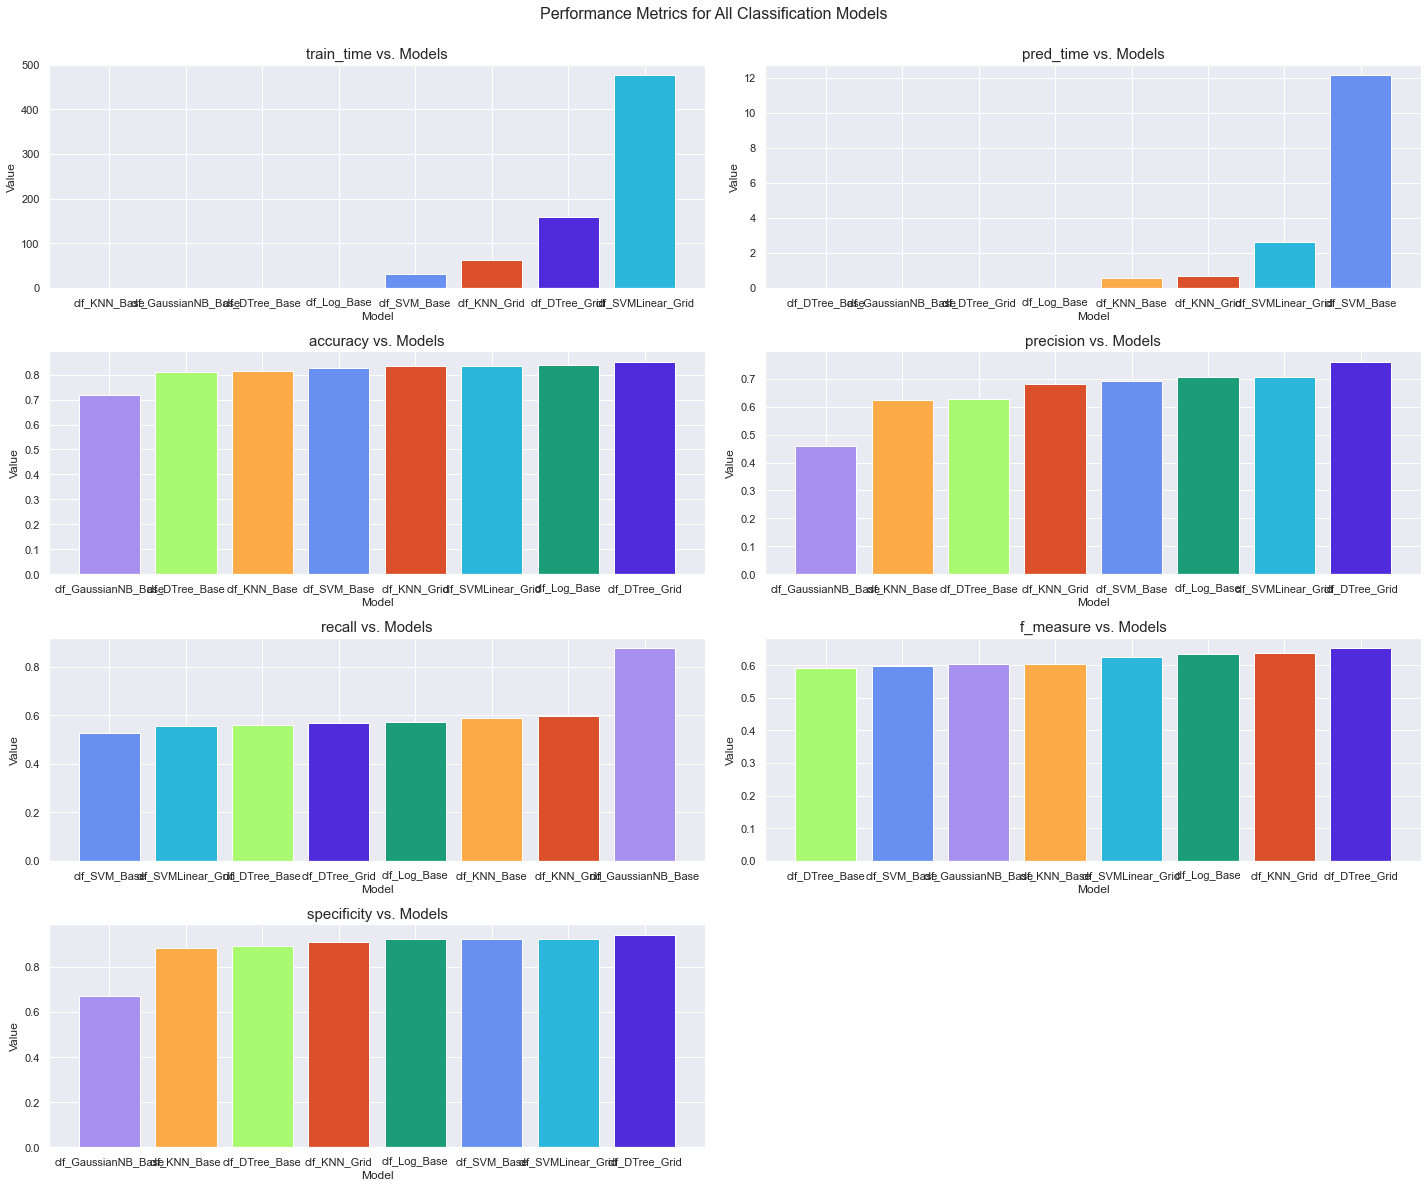

In [316]:
fig = plt.figure(figsize=(20,20))
for j, label in enumerate(["train_time","pred_time","accuracy","precision","recall","f_measure","specificity"]):
    ax = fig.add_subplot(5, 2, j+1)
    temp = resultsComb.sort_values(by=[label], axis=1)
    ax.bar(temp.loc[label].index, temp.loc[label].values, color = list(temp.loc["colors"]))
    ax.set_title(f"{label} vs. Models", fontsize=15)
    ax.set_xlabel("Model")
    ax.set_ylabel("Value")
plt.suptitle("Performance Metrics for All Classification Models", fontsize = 16, y = 1)
plt.tight_layout()
plt.show()

#### Only Optimized Model Metrics

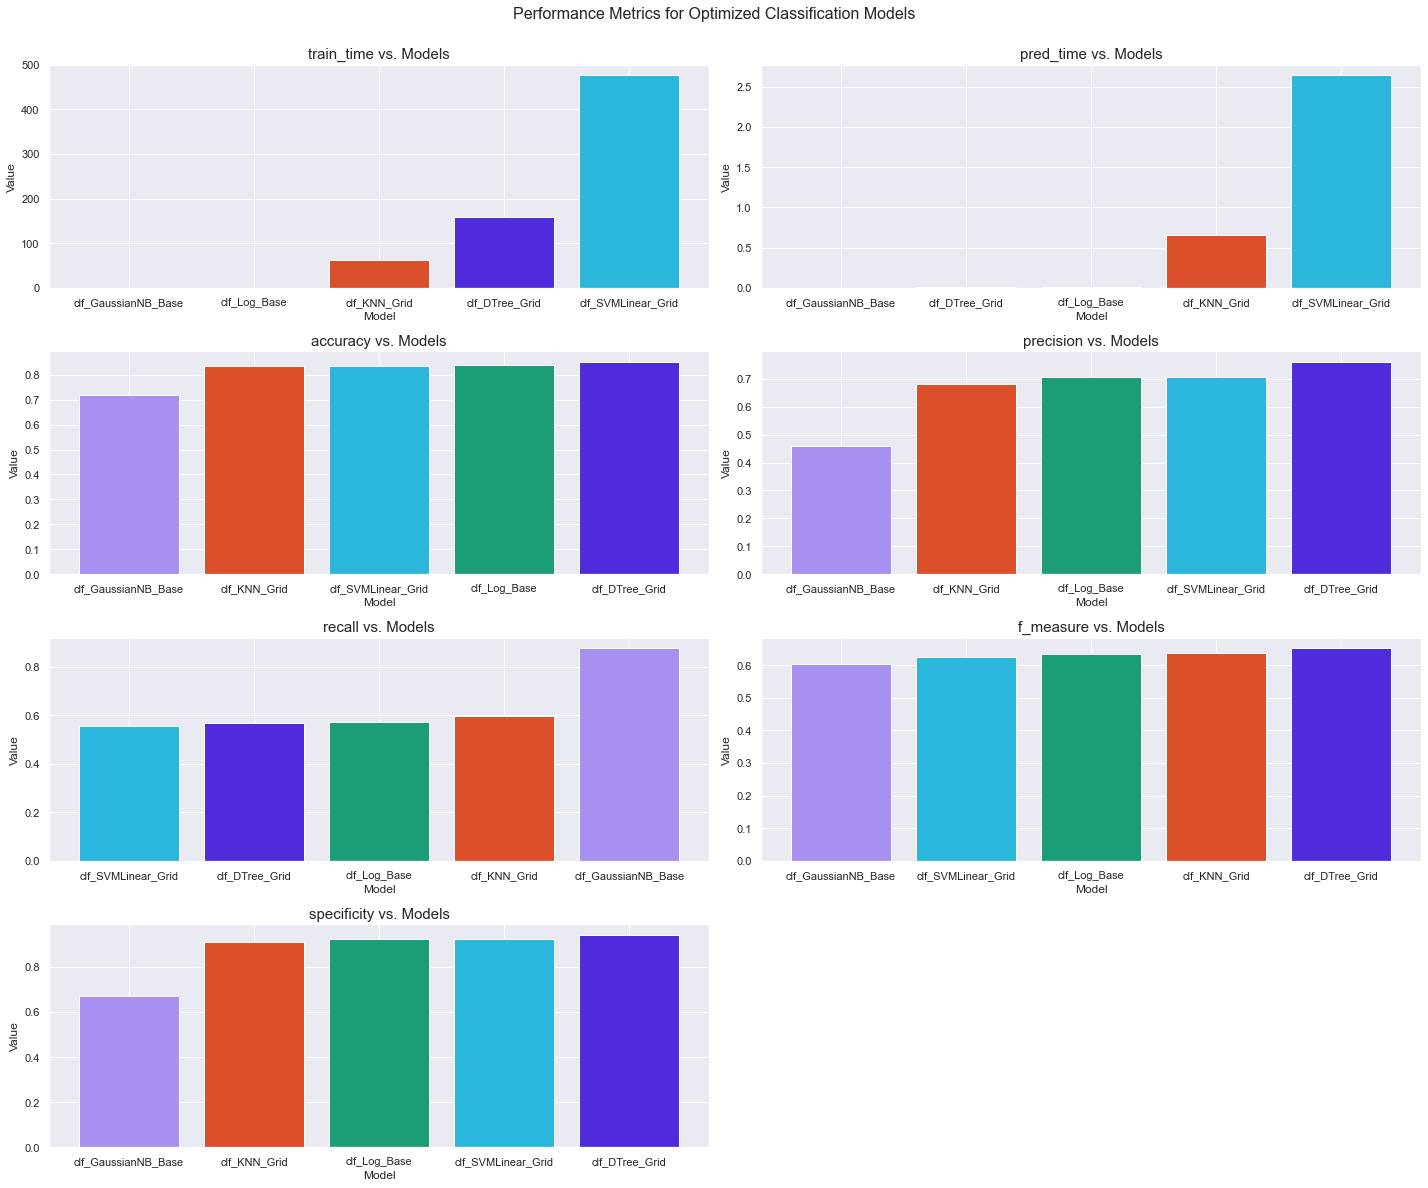

In [317]:
fig = plt.figure(figsize=(20,20))
cols = list(set(resultsComb.columns)-{"clf_DTree_Base","clf_KNN_Base","clf_SVM_Base"})
for j, label in enumerate(["train_time","pred_time","accuracy","precision","recall","f_measure","specificity"]):
    ax = fig.add_subplot(5, 2, j+1)
    temp = resultsComb[cols].sort_values(by=[label], axis=1)
    ax.bar(temp.loc[label].index, temp.loc[label].values, color = list(temp.loc["colors"]))
    ax.set_title(f"{label} vs. Models", fontsize=15)
    ax.set_xlabel("Model")
    ax.set_ylabel("Value")
plt.suptitle("Performance Metrics for Optimized Classification Models", fontsize = 16, y = 1)
plt.tight_layout()
plt.show()

#### Confusion Matrix for Optimized Models

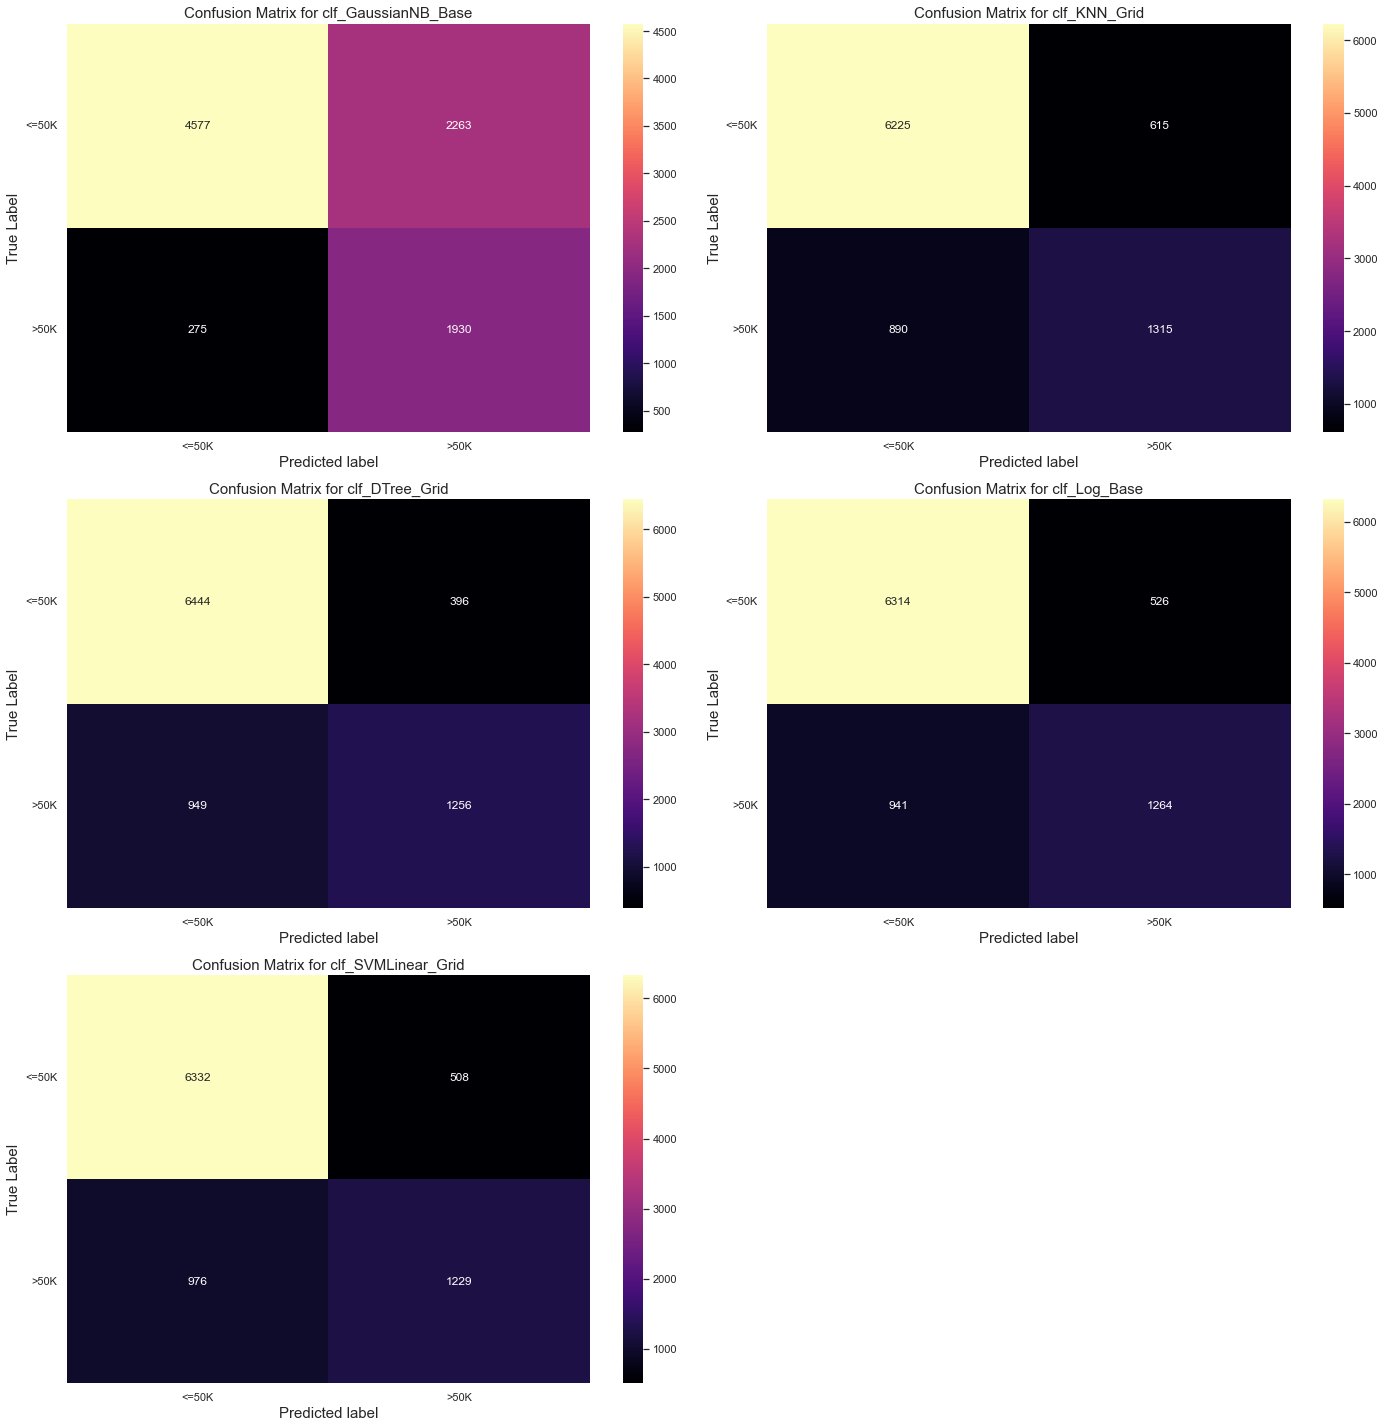

In [468]:
fig = plt.figure(figsize=(20,20))
j=0
for index, value in resultsComb[cols].loc['confusion'].iteritems():
    ax = fig.add_subplot(3, 2, j+1)
    sns.heatmap(value.reshape(2, -1), annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_xlabel("Predicted label", fontsize =15)
    ax.set_xticklabels(["<=50K",">50K"])
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_yticklabels(["<=50K",">50K"], rotation = 0)
    ax.set_title(f"Confusion Matrix for {index}", fontsize=15)
    j+=1
plt.tight_layout()
plt.show()

#### ROC and AUC for Optimized Models

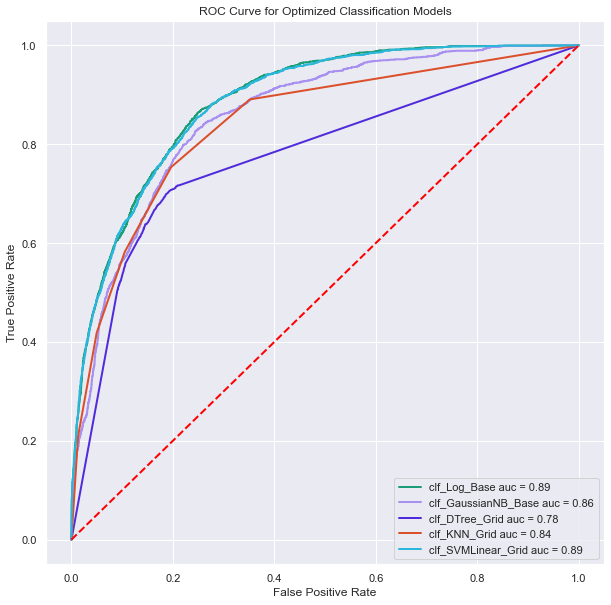

In [385]:
fig = plt.figure(figsize=(10,10))
labels = ["clf_Log_Base", "clf_GaussianNB_Base", "clf_DTree_Grid", "clf_KNN_Grid", "clf_SVMLinear_Grid"]
for i, clf in enumerate([clf_Log, clf_Bayes, clf_DTree_Grid, clf_KNN_Grid, clf_SVMLinear_Grid]):
        if clf.__class__.__name__ == "SVC":
            fpr, tpr, _ = roc_curve(y_test, clf.decision_function(X_test3))
        else:
            fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test3)[:,1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=resultsComb[labels].loc["colors"].values[i],lw=2, label=f'{labels[i]} auc = {roc_auc:.2f}')
    
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Optimized Classification Models')
plt.legend()
plt.show()

# Evaluate and Determine best model